In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math

2023-02-23 13:50:25.864637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def findkernel(temp_grad, F_flux, time_interval, N_points, tau, kernel_size, pre_kernel, tspan, n_epoch):

    # build single layer conv1d 
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    
    input_series = keras.layers.Input(temp_grad.shape[1:])
    output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
    model = keras.Model(input_series, output_series)
    weights = model.get_weights() # store the initial random weights
    new_weights = [np.random.randn(*w.shape) for w in weights]
    adam = keras.optimizers.Adam(epsilon = 1e-02) #adjust epsilon
    model.compile(
        optimizer=adam,
        loss= 'mean_squared_error',
        metrics=['mean_squared_error'])
    #model.summary()
    
    # split train and test sets
    X_train, X_rem, y_train, y_rem = train_test_split(temp_grad, F_flux, train_size=0.8)
    
    # train the model
    history = model.fit(X_train, y_train, epochs=n_epoch, validation_data=(X_rem, y_rem), callbacks=[callback])
    val_loss = history.history['val_loss']
    
    # get the kernel
    conv_kernel = model.weights[0][:,0,0]
    a = tf.constant(conv_kernel)
    conv_kernel = a.numpy()
    conv_kernel = conv_kernel[::-1]
    
    # reset random initial weights
    model.set_weights(new_weights)
    
    return (conv_kernel, val_loss)

In [8]:
time_interval = 6 # corresponding time interval duration in say days
N_points = 365; # length in time
y_sample = 10; #number of years
kernel_size = 20 # truncate the kernel to include some small number of points since we are assuming it decays with time
n_kernel = 256; # number of neural network
tspan = np.linspace(0, time_interval, N_points)
n_epoch = 100; # epoch of each neural network
n_avg = 10; #average over 10 days


tau = 0.2 # define pre-defined kernel
pre_kernel = np.exp(-tspan/tau) 
pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
tspan_kernel = tspan[:kernel_size]
tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries


In [9]:
# real data
dT_dx = np.load('/Users/liyiran/Desktop/eddymemory/eddydata/dT_bar_dx.npy')
dT_dy = np.load('/Users/liyiran/Desktop/eddymemory/eddydata/dT_bar_dy.npy')
uT_prime_bar = np.load('/Users/liyiran/Desktop/eddymemory/eddydata/uT_prime_bar.npy')
vT_prime_bar = np.load('/Users/liyiran/Desktop/eddymemory/eddydata/vT_prime_bar.npy')

In [10]:
#run the model
K_kernel = np.zeros((n_kernel,kernel_size))
L_val = np.zeros((n_kernel, n_epoch))

dT_dx = dT_dx[0:y_sample*N_points-365%n_avg*y_sample,:,:]
dT_dx = np.average(dT_dx.reshape(-1, n_avg), axis=1) 
dT_dx = np.reshape(dT_dx,(y_sample,365//n_avg,16,16)) 


dT_dy = dT_dy[0:y_sample*N_points-365%n_avg*y_sample,:,:]
dT_dy = np.average(dT_dy.reshape(-1, n_avg), axis=1)
dT_dy = np.reshape(dT_dy,(y_sample,365//n_avg,16,16)) 


uT_prime_bar = uT_prime_bar[0:y_sample*N_points-365%n_avg*y_sample,:,:]
uT_prime_bar = np.average(uT_prime_bar.reshape(-1, n_avg), axis=1)
uT_prime_bar = np.reshape(uT_prime_bar,(y_sample,365//n_avg,16,16)) 
uT_prime_bar = uT_prime_bar[:,kernel_size-1:,:,:] 

vT_prime_bar = vT_prime_bar[0:y_sample*N_points-365%n_avg*y_sample,:,:]
vT_prime_bar = np.average(vT_prime_bar.reshape(-1, n_avg), axis=1)
vT_prime_bar = np.reshape(vT_prime_bar,(y_sample,365//n_avg,16,16)) 
vT_prime_bar = vT_prime_bar[:,kernel_size-1:,:,:] 


In [11]:
for i in range(dT_dx.shape[2]):
    for j in range(dT_dx.shape[2]):
        
        dT = np.dstack((dT_dx[:,:,i,j],dT_dy[:,:,i,j]))
        flux = np.dstack((uT_prime_bar[:,:,i,j],vT_prime_bar[:,:,i,j]))
                                                      
        # save kernel
        # input size (10, 73, 16, 16)
        K_kernel[i*dT_dx.shape[2]+j,:] = findkernel(dT,flux,time_interval,N_points,tau,kernel_size,pre_kernel,tspan,n_epoch)[0]    

Epoch 1/100


2023-02-20 16:28:23.620127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 558ms/step - loss: 4.9147e-04 - mean_squared_error: 4.9147e-04 - val_loss: 1.9430e-04 - val_mean_squared_error: 1.9430e-04
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 4.9136e-04 - mean_squared_error: 4.9136e-04 - val_loss: 1.9414e-04 - val_mean_squared_error: 1.9414e-04
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 4.9122e-04 - mean_squared_error: 4.9122e-04 - val_loss: 1.9395e-04 - val_mean_squared_error: 1.9395e-04
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 4.9104e-04 - mean_squared_error: 4.9104e-04 - val_loss: 1.9373e-04 - val_mean_squared_error: 1.9373e-04
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 4.9085e-04 - mean_squared_error: 4.9085e-04 - val_loss: 1.9350e-04 - val_mean_squared_error: 1.9350e-04
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 4.9063e-04 - mean_squared_error: 4.9063e-04 - val_loss: 1.9

1/1 [==============================] - 0s 27ms/step - loss: 5.1374e-04 - mean_squared_error: 5.1374e-04 - val_loss: 5.6194e-04 - val_mean_squared_error: 5.6194e-04
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 5.1352e-04 - mean_squared_error: 5.1352e-04 - val_loss: 5.6163e-04 - val_mean_squared_error: 5.6163e-04
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 5.1328e-04 - mean_squared_error: 5.1328e-04 - val_loss: 5.6130e-04 - val_mean_squared_error: 5.6130e-04
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 5.1303e-04 - mean_squared_error: 5.1303e-04 - val_loss: 5.6096e-04 - val_mean_squared_error: 5.6096e-04
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 5.1277e-04 - mean_squared_error: 5.1277e-04 - val_loss: 5.6060e-04 - val_mean_squared_error: 5.6060e-04
Epoch 10/100
1/1 [==============================] - 0s 29ms/step - loss: 5.1250e-04 - mean_squared_error: 5.1250e-04 - val_loss: 5.6

1/1 [==============================] - 0s 403ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.2127e-04 - val_mean_squared_error: 6.2127e-04
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.2089e-04 - val_mean_squared_error: 6.2089e-04
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.2043e-04 - val_mean_squared_error: 6.2043e-04
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.1991e-04 - val_mean_squared_error: 6.1991e-04
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.1935e-04 - val_mean_squared_error: 6.1935e-04
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.1874e-04 - val_mean_squared_error: 6.1874e-04
Epo

Epoch 8/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 10/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 11/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 12/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 13/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 14/100
1/1 [==================

Epoch 28/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0894e-04 - val_mean_squared_error: 9.0894e-04
Epoch 29/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0833e-04 - val_mean_squared_error: 9.0833e-04
Epoch 30/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0773e-04 - val_mean_squared_error: 9.0773e-04
Epoch 31/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0715e-04 - val_mean_squared_error: 9.0715e-04
Epoch 32/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0660e-04 - val_mean_squared_error: 9.0660e-04
Epoch 33/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0607e-04 - val_mean_squared_erro

Epoch 26/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.1144e-04 - val_mean_squared_error: 7.1144e-04
Epoch 27/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.1022e-04 - val_mean_squared_error: 7.1022e-04
Epoch 28/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0910e-04 - val_mean_squared_error: 7.0910e-04
Epoch 29/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0806e-04 - val_mean_squared_error: 7.0806e-04
Epoch 30/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0710e-04 - val_mean_squared_error: 7.0710e-04
Epoch 31/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0624e-04 - val_mean_squared_erro

1/1 [==============================] - 0s 29ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss: 3.7400e-04 - val_mean_squared_error: 3.7400e-04
Epoch 74/100
1/1 [==============================] - 0s 28ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss: 3.7400e-04 - val_mean_squared_error: 3.7400e-04
Epoch 75/100
1/1 [==============================] - 0s 29ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss: 3.7399e-04 - val_mean_squared_error: 3.7399e-04
Epoch 76/100
1/1 [==============================] - 0s 31ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss: 3.7399e-04 - val_mean_squared_error: 3.7399e-04
Epoch 77/100
1/1 [==============================] - 0s 32ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss: 3.7399e-04 - val_mean_squared_error: 3.7399e-04
Epoch 78/100
1/1 [==============================] - 0s 29ms/step - loss: 4.0493e-04 - mean_squared_error: 4.0493e-04 - val_loss:

Epoch 11/100
1/1 [==============================] - 0s 31ms/step - loss: 3.2658e-04 - mean_squared_error: 3.2658e-04 - val_loss: 1.9764e-04 - val_mean_squared_error: 1.9764e-04
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 3.2657e-04 - mean_squared_error: 3.2657e-04 - val_loss: 1.9763e-04 - val_mean_squared_error: 1.9763e-04
Epoch 13/100
1/1 [==============================] - 0s 36ms/step - loss: 3.2657e-04 - mean_squared_error: 3.2657e-04 - val_loss: 1.9763e-04 - val_mean_squared_error: 1.9763e-04
Epoch 14/100
1/1 [==============================] - 0s 32ms/step - loss: 3.2656e-04 - mean_squared_error: 3.2656e-04 - val_loss: 1.9763e-04 - val_mean_squared_error: 1.9763e-04
Epoch 15/100
1/1 [==============================] - 0s 31ms/step - loss: 3.2656e-04 - mean_squared_error: 3.2656e-04 - val_loss: 1.9763e-04 - val_mean_squared_error: 1.9763e-04
Epoch 16/100
1/1 [==============================] - 0s 36ms/step - loss: 3.2656e-04 - mean_squared_error: 3.2656e-0

1/1 [==============================] - 0s 39ms/step - loss: 1.2664e-04 - mean_squared_error: 1.2664e-04 - val_loss: 5.7096e-05 - val_mean_squared_error: 5.7096e-05
Epoch 41/100
1/1 [==============================] - 0s 35ms/step - loss: 1.2664e-04 - mean_squared_error: 1.2664e-04 - val_loss: 5.7085e-05 - val_mean_squared_error: 5.7085e-05
Epoch 42/100
1/1 [==============================] - 0s 32ms/step - loss: 1.2664e-04 - mean_squared_error: 1.2664e-04 - val_loss: 5.7074e-05 - val_mean_squared_error: 5.7074e-05
Epoch 43/100
1/1 [==============================] - 0s 36ms/step - loss: 1.2664e-04 - mean_squared_error: 1.2664e-04 - val_loss: 5.7064e-05 - val_mean_squared_error: 5.7064e-05
Epoch 44/100
1/1 [==============================] - 0s 38ms/step - loss: 1.2664e-04 - mean_squared_error: 1.2664e-04 - val_loss: 5.7054e-05 - val_mean_squared_error: 5.7054e-05
Epoch 45/100
1/1 [==============================] - 0s 35ms/step - loss: 1.2663e-04 - mean_squared_error: 1.2663e-04 - val_loss:

1/1 [==============================] - 0s 33ms/step - loss: 9.4928e-06 - mean_squared_error: 9.4928e-06 - val_loss: 2.0204e-05 - val_mean_squared_error: 2.0204e-05
Epoch 26/100
1/1 [==============================] - 0s 32ms/step - loss: 9.4890e-06 - mean_squared_error: 9.4890e-06 - val_loss: 2.0188e-05 - val_mean_squared_error: 2.0188e-05
Epoch 27/100
1/1 [==============================] - 0s 35ms/step - loss: 9.4853e-06 - mean_squared_error: 9.4853e-06 - val_loss: 2.0173e-05 - val_mean_squared_error: 2.0173e-05
Epoch 28/100
1/1 [==============================] - 0s 35ms/step - loss: 9.4818e-06 - mean_squared_error: 9.4818e-06 - val_loss: 2.0159e-05 - val_mean_squared_error: 2.0159e-05
Epoch 29/100
1/1 [==============================] - 0s 31ms/step - loss: 9.4786e-06 - mean_squared_error: 9.4786e-06 - val_loss: 2.0144e-05 - val_mean_squared_error: 2.0144e-05
Epoch 30/100
1/1 [==============================] - 0s 31ms/step - loss: 9.4755e-06 - mean_squared_error: 9.4755e-06 - val_loss:

1/1 [==============================] - 0s 33ms/step - loss: 2.3613e-04 - mean_squared_error: 2.3613e-04 - val_loss: 4.5353e-05 - val_mean_squared_error: 4.5353e-05
Epoch 25/100
1/1 [==============================] - 0s 35ms/step - loss: 2.3600e-04 - mean_squared_error: 2.3600e-04 - val_loss: 4.5099e-05 - val_mean_squared_error: 4.5099e-05
Epoch 26/100
1/1 [==============================] - 0s 33ms/step - loss: 2.3589e-04 - mean_squared_error: 2.3589e-04 - val_loss: 4.4851e-05 - val_mean_squared_error: 4.4851e-05
Epoch 27/100
1/1 [==============================] - 0s 37ms/step - loss: 2.3577e-04 - mean_squared_error: 2.3577e-04 - val_loss: 4.4609e-05 - val_mean_squared_error: 4.4609e-05
Epoch 28/100
1/1 [==============================] - 0s 29ms/step - loss: 2.3567e-04 - mean_squared_error: 2.3567e-04 - val_loss: 4.4374e-05 - val_mean_squared_error: 4.4374e-05
Epoch 29/100
1/1 [==============================] - 0s 33ms/step - loss: 2.3556e-04 - mean_squared_error: 2.3556e-04 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 4.8147e-04 - mean_squared_error: 4.8147e-04 - val_loss: 2.0956e-04 - val_mean_squared_error: 2.0956e-04
Epoch 30/100
1/1 [==============================] - 0s 36ms/step - loss: 4.8145e-04 - mean_squared_error: 4.8145e-04 - val_loss: 2.0949e-04 - val_mean_squared_error: 2.0949e-04
Epoch 31/100
1/1 [==============================] - 0s 36ms/step - loss: 4.8144e-04 - mean_squared_error: 4.8144e-04 - val_loss: 2.0943e-04 - val_mean_squared_error: 2.0943e-04
Epoch 32/100
1/1 [==============================] - 0s 34ms/step - loss: 4.8142e-04 - mean_squared_error: 4.8142e-04 - val_loss: 2.0937e-04 - val_mean_squared_error: 2.0937e-04
Epoch 33/100
1/1 [==============================] - 0s 33ms/step - loss: 4.8141e-04 - mean_squared_error: 4.8141e-04 - val_loss: 2.0931e-04 - val_mean_squared_error: 2.0931e-04
Epoch 34/100
1/1 [==============================] - 0s 34ms/step - loss: 4.8140e-04 - mean_squared_error: 4.8140e-04 - val_loss:

1/1 [==============================] - 0s 163ms/step - loss: 5.9763e-04 - mean_squared_error: 5.9763e-04 - val_loss: 3.7732e-04 - val_mean_squared_error: 3.7732e-04
Epoch 38/100
1/1 [==============================] - 0s 35ms/step - loss: 5.9747e-04 - mean_squared_error: 5.9747e-04 - val_loss: 3.7667e-04 - val_mean_squared_error: 3.7667e-04
Epoch 39/100
1/1 [==============================] - 0s 62ms/step - loss: 5.9732e-04 - mean_squared_error: 5.9732e-04 - val_loss: 3.7605e-04 - val_mean_squared_error: 3.7605e-04
Epoch 40/100
1/1 [==============================] - 0s 115ms/step - loss: 5.9718e-04 - mean_squared_error: 5.9718e-04 - val_loss: 3.7546e-04 - val_mean_squared_error: 3.7546e-04
Epoch 41/100
1/1 [==============================] - 0s 54ms/step - loss: 5.9705e-04 - mean_squared_error: 5.9705e-04 - val_loss: 3.7488e-04 - val_mean_squared_error: 3.7488e-04
Epoch 42/100
1/1 [==============================] - 0s 93ms/step - loss: 5.9693e-04 - mean_squared_error: 5.9693e-04 - val_los

Epoch 28/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 29/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 30/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 31/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 32/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 33/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 34/100
1/1 [================

Epoch 79/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 80/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 81/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 82/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 83/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 84/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 85/100
1/1 [================

Epoch 21/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 22/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 23/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 24/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 25/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 26/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 27/100
1/1 [================

Epoch 72/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 73/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 74/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 75/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 76/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 77/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 78/100
1/1 [================

Epoch 29/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 30/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 31/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 32/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 33/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 34/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 35/100
1/1 [================

Epoch 80/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 81/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 82/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 83/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 84/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 85/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 86/100
1/1 [================

1/1 [==============================] - 0s 44ms/step - loss: 8.0777e-04 - mean_squared_error: 8.0777e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 1/100
1/1 [==============================] - 0s 455ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
1/1 [==========================

Epoch 51/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 52/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 53/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 54/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 55/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 56/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 57/100
1/1 [================

1/1 [==============================] - 0s 38ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 65/100
1/1 [==============================] - 0s 39ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 66/100
1/1 [==============================] - 0s 38ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 67/100
1/1 [==============================] - 0s 46ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 68/100
1/1 [==============================] - 0s 37ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 69/100
1/1 [==============================] - 0s 33ms/step - loss: 6.6517e-04 - mean_squared_error: 6.6517e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010

1/1 [==============================] - 0s 41ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss: 6.1539e-04 - val_mean_squared_error: 6.1539e-04
Epoch 75/100
1/1 [==============================] - 0s 43ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss: 6.1539e-04 - val_mean_squared_error: 6.1539e-04
Epoch 76/100
1/1 [==============================] - 0s 45ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss: 6.1538e-04 - val_mean_squared_error: 6.1538e-04
Epoch 77/100
1/1 [==============================] - 0s 68ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss: 6.1538e-04 - val_mean_squared_error: 6.1538e-04
Epoch 78/100
1/1 [==============================] - 0s 40ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss: 6.1537e-04 - val_mean_squared_error: 6.1537e-04
Epoch 79/100
1/1 [==============================] - 0s 39ms/step - loss: 6.1727e-04 - mean_squared_error: 6.1727e-04 - val_loss:

1/1 [==============================] - 0s 35ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss: 1.0705e-04 - val_mean_squared_error: 1.0705e-04
Epoch 48/100
1/1 [==============================] - 0s 38ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss: 1.0704e-04 - val_mean_squared_error: 1.0704e-04
Epoch 49/100
1/1 [==============================] - 0s 35ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss: 1.0703e-04 - val_mean_squared_error: 1.0703e-04
Epoch 50/100
1/1 [==============================] - 0s 37ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss: 1.0703e-04 - val_mean_squared_error: 1.0703e-04
Epoch 51/100
1/1 [==============================] - 0s 34ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss: 1.0702e-04 - val_mean_squared_error: 1.0702e-04
Epoch 52/100
1/1 [==============================] - 0s 39ms/step - loss: 1.3656e-04 - mean_squared_error: 1.3656e-04 - val_loss:

1/1 [==============================] - 0s 44ms/step - loss: 2.3456e-04 - mean_squared_error: 2.3456e-04 - val_loss: 2.3990e-04 - val_mean_squared_error: 2.3990e-04
Epoch 56/100
1/1 [==============================] - 0s 39ms/step - loss: 2.3456e-04 - mean_squared_error: 2.3456e-04 - val_loss: 2.3987e-04 - val_mean_squared_error: 2.3987e-04
Epoch 57/100
1/1 [==============================] - 0s 43ms/step - loss: 2.3456e-04 - mean_squared_error: 2.3456e-04 - val_loss: 2.3984e-04 - val_mean_squared_error: 2.3984e-04
Epoch 58/100
1/1 [==============================] - 0s 43ms/step - loss: 2.3456e-04 - mean_squared_error: 2.3456e-04 - val_loss: 2.3982e-04 - val_mean_squared_error: 2.3982e-04
Epoch 59/100
1/1 [==============================] - 0s 39ms/step - loss: 2.3456e-04 - mean_squared_error: 2.3456e-04 - val_loss: 2.3980e-04 - val_mean_squared_error: 2.3980e-04
Epoch 60/100
1/1 [==============================] - 0s 43ms/step - loss: 2.3455e-04 - mean_squared_error: 2.3455e-04 - val_loss:

1/1 [==============================] - 0s 34ms/step - loss: 2.3980e-05 - mean_squared_error: 2.3980e-05 - val_loss: 3.3547e-05 - val_mean_squared_error: 3.3547e-05
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 2.3976e-05 - mean_squared_error: 2.3976e-05 - val_loss: 3.3547e-05 - val_mean_squared_error: 3.3547e-05
Epoch 1/100
1/1 [==============================] - 1s 650ms/step - loss: 1.0372e-05 - mean_squared_error: 1.0372e-05 - val_loss: 3.9983e-05 - val_mean_squared_error: 3.9983e-05
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 1.0372e-05 - mean_squared_error: 1.0372e-05 - val_loss: 3.9987e-05 - val_mean_squared_error: 3.9987e-05
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 1.0372e-05 - mean_squared_error: 1.0372e-05 - val_loss: 3.9991e-05 - val_mean_squared_error: 3.9991e-05
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 1.0371e-05 - mean_squared_error: 1.0371e-05 - val_loss: 3.9

1/1 [==============================] - 0s 35ms/step - loss: 9.0164e-06 - mean_squared_error: 9.0164e-06 - val_loss: 5.9111e-06 - val_mean_squared_error: 5.9111e-06
Epoch 1/100
1/1 [==============================] - 0s 412ms/step - loss: 7.5869e-06 - mean_squared_error: 7.5869e-06 - val_loss: 7.4782e-06 - val_mean_squared_error: 7.4782e-06
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 7.5854e-06 - mean_squared_error: 7.5854e-06 - val_loss: 7.4780e-06 - val_mean_squared_error: 7.4780e-06
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 7.5833e-06 - mean_squared_error: 7.5833e-06 - val_loss: 7.4777e-06 - val_mean_squared_error: 7.4777e-06
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 7.5807e-06 - mean_squared_error: 7.5807e-06 - val_loss: 7.4774e-06 - val_mean_squared_error: 7.4774e-06
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 7.5778e-06 - mean_squared_error: 7.5778e-06 - val_loss: 7.4

1/1 [==============================] - 0s 36ms/step - loss: 4.5437e-04 - mean_squared_error: 4.5437e-04 - val_loss: 5.5747e-04 - val_mean_squared_error: 5.5747e-04
Epoch 43/100
1/1 [==============================] - 0s 35ms/step - loss: 4.5435e-04 - mean_squared_error: 4.5435e-04 - val_loss: 5.5735e-04 - val_mean_squared_error: 5.5735e-04
Epoch 44/100
1/1 [==============================] - 0s 33ms/step - loss: 4.5433e-04 - mean_squared_error: 4.5433e-04 - val_loss: 5.5724e-04 - val_mean_squared_error: 5.5724e-04
Epoch 45/100
1/1 [==============================] - 0s 37ms/step - loss: 4.5431e-04 - mean_squared_error: 4.5431e-04 - val_loss: 5.5713e-04 - val_mean_squared_error: 5.5713e-04
Epoch 46/100
1/1 [==============================] - 0s 41ms/step - loss: 4.5430e-04 - mean_squared_error: 4.5430e-04 - val_loss: 5.5703e-04 - val_mean_squared_error: 5.5703e-04
Epoch 47/100
1/1 [==============================] - 0s 39ms/step - loss: 4.5428e-04 - mean_squared_error: 4.5428e-04 - val_loss:

1/1 [==============================] - 0s 44ms/step - loss: 8.6473e-04 - mean_squared_error: 8.6473e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 38/100
1/1 [==============================] - 0s 45ms/step - loss: 8.6469e-04 - mean_squared_error: 8.6469e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 39/100
1/1 [==============================] - 0s 43ms/step - loss: 8.6465e-04 - mean_squared_error: 8.6465e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 40/100
1/1 [==============================] - 0s 36ms/step - loss: 8.6462e-04 - mean_squared_error: 8.6462e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 41/100
1/1 [==============================] - 0s 40ms/step - loss: 8.6459e-04 - mean_squared_error: 8.6459e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 42/100
1/1 [==============================] - 0s 43ms/step - loss: 8.6456e-04 - mean_squared_error: 8.6456e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

1/1 [==============================] - 0s 39ms/step - loss: 8.6560e-04 - mean_squared_error: 8.6560e-04 - val_loss: 8.8320e-04 - val_mean_squared_error: 8.8320e-04
Epoch 46/100
1/1 [==============================] - 0s 40ms/step - loss: 8.6548e-04 - mean_squared_error: 8.6548e-04 - val_loss: 8.8300e-04 - val_mean_squared_error: 8.8300e-04
Epoch 47/100
1/1 [==============================] - 0s 59ms/step - loss: 8.6537e-04 - mean_squared_error: 8.6537e-04 - val_loss: 8.8282e-04 - val_mean_squared_error: 8.8282e-04
Epoch 48/100
1/1 [==============================] - 0s 36ms/step - loss: 8.6526e-04 - mean_squared_error: 8.6526e-04 - val_loss: 8.8266e-04 - val_mean_squared_error: 8.8266e-04
Epoch 49/100
1/1 [==============================] - 0s 29ms/step - loss: 8.6517e-04 - mean_squared_error: 8.6517e-04 - val_loss: 8.8250e-04 - val_mean_squared_error: 8.8250e-04
Epoch 50/100
1/1 [==============================] - 0s 34ms/step - loss: 8.6509e-04 - mean_squared_error: 8.6509e-04 - val_loss:

Epoch 51/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 52/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 53/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 54/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 55/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 56/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 57/100
1/1 [================

Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 8/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 12/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 13/100
1/1 [===================

Epoch 39/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 40/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 41/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 42/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 43/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 44/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 45/100
1/1 [================

Epoch 88/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8949e-04 - val_mean_squared_error: 9.8949e-04
Epoch 89/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8948e-04 - val_mean_squared_error: 9.8948e-04
Epoch 90/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8948e-04 - val_mean_squared_error: 9.8948e-04
Epoch 91/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8947e-04 - val_mean_squared_error: 9.8947e-04
Epoch 92/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8947e-04 - val_mean_squared_error: 9.8947e-04
Epoch 93/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.8948e-04 - val_mean_squared_erro

1/1 [==============================] - 0s 32ms/step - loss: 8.3959e-04 - mean_squared_error: 8.3959e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 8.3902e-04 - mean_squared_error: 8.3902e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 8.3841e-04 - mean_squared_error: 8.3841e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 8.3776e-04 - mean_squared_error: 8.3776e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 8.3710e-04 - mean_squared_error: 8.3710e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 10/100
1/1 [==============================] - 0s 31ms/step - loss: 8.3641e-04 - mean_squared_error: 8.3641e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epo

1/1 [==============================] - 0s 35ms/step - loss: 6.9182e-04 - mean_squared_error: 6.9182e-04 - val_loss: 5.8912e-04 - val_mean_squared_error: 5.8912e-04
Epoch 10/100
1/1 [==============================] - 0s 41ms/step - loss: 6.9137e-04 - mean_squared_error: 6.9137e-04 - val_loss: 5.8829e-04 - val_mean_squared_error: 5.8829e-04
Epoch 11/100
1/1 [==============================] - 0s 39ms/step - loss: 6.9092e-04 - mean_squared_error: 6.9092e-04 - val_loss: 5.8743e-04 - val_mean_squared_error: 5.8743e-04
Epoch 12/100
1/1 [==============================] - 0s 34ms/step - loss: 6.9046e-04 - mean_squared_error: 6.9046e-04 - val_loss: 5.8657e-04 - val_mean_squared_error: 5.8657e-04
Epoch 13/100
1/1 [==============================] - 0s 35ms/step - loss: 6.8999e-04 - mean_squared_error: 6.8999e-04 - val_loss: 5.8569e-04 - val_mean_squared_error: 5.8569e-04
Epoch 14/100
1/1 [==============================] - 0s 33ms/step - loss: 6.8953e-04 - mean_squared_error: 6.8953e-04 - val_loss:

Epoch 1/100
1/1 [==============================] - 0s 419ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - val_loss: 1.9744e-04 - val_mean_squared_error: 1.9744e-04
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - val_loss: 1.9744e-04 - val_mean_squared_error: 1.9744e-04
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - val_loss: 1.9744e-04 - val_mean_squared_error: 1.9744e-04
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - val_loss: 1.9743e-04 - val_mean_squared_error: 1.9743e-04
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - val_loss: 1.9743e-04 - val_mean_squared_error: 1.9743e-04
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 1.8714e-04 - mean_squared_error: 1.8714e-04 - v

1/1 [==============================] - 0s 39ms/step - loss: 5.0992e-04 - mean_squared_error: 5.0992e-04 - val_loss: 4.8657e-04 - val_mean_squared_error: 4.8657e-04
Epoch 12/100
1/1 [==============================] - 0s 38ms/step - loss: 5.0988e-04 - mean_squared_error: 5.0988e-04 - val_loss: 4.8655e-04 - val_mean_squared_error: 4.8655e-04
Epoch 13/100
1/1 [==============================] - 0s 41ms/step - loss: 5.0984e-04 - mean_squared_error: 5.0984e-04 - val_loss: 4.8652e-04 - val_mean_squared_error: 4.8652e-04
Epoch 14/100
1/1 [==============================] - 0s 36ms/step - loss: 5.0980e-04 - mean_squared_error: 5.0980e-04 - val_loss: 4.8650e-04 - val_mean_squared_error: 4.8650e-04
Epoch 15/100
1/1 [==============================] - 0s 61ms/step - loss: 5.0976e-04 - mean_squared_error: 5.0976e-04 - val_loss: 4.8648e-04 - val_mean_squared_error: 4.8648e-04
Epoch 16/100
1/1 [==============================] - 0s 68ms/step - loss: 5.0972e-04 - mean_squared_error: 5.0972e-04 - val_loss:

1/1 [==============================] - 0s 45ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss: 1.6650e-04 - val_mean_squared_error: 1.6650e-04
Epoch 65/100
1/1 [==============================] - 0s 45ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss: 1.6649e-04 - val_mean_squared_error: 1.6649e-04
Epoch 66/100
1/1 [==============================] - 0s 43ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss: 1.6648e-04 - val_mean_squared_error: 1.6648e-04
Epoch 67/100
1/1 [==============================] - 0s 47ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss: 1.6648e-04 - val_mean_squared_error: 1.6648e-04
Epoch 68/100
1/1 [==============================] - 0s 45ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss: 1.6647e-04 - val_mean_squared_error: 1.6647e-04
Epoch 69/100
1/1 [==============================] - 0s 41ms/step - loss: 1.3465e-04 - mean_squared_error: 1.3465e-04 - val_loss:

1/1 [==============================] - 0s 34ms/step - loss: 1.2468e-04 - mean_squared_error: 1.2468e-04 - val_loss: 1.9481e-04 - val_mean_squared_error: 1.9481e-04
Epoch 22/100
1/1 [==============================] - 0s 38ms/step - loss: 1.2467e-04 - mean_squared_error: 1.2467e-04 - val_loss: 1.9478e-04 - val_mean_squared_error: 1.9478e-04
Epoch 23/100
1/1 [==============================] - 0s 41ms/step - loss: 1.2466e-04 - mean_squared_error: 1.2466e-04 - val_loss: 1.9475e-04 - val_mean_squared_error: 1.9475e-04
Epoch 24/100
1/1 [==============================] - 0s 37ms/step - loss: 1.2465e-04 - mean_squared_error: 1.2465e-04 - val_loss: 1.9473e-04 - val_mean_squared_error: 1.9473e-04
Epoch 25/100
1/1 [==============================] - 0s 34ms/step - loss: 1.2464e-04 - mean_squared_error: 1.2464e-04 - val_loss: 1.9470e-04 - val_mean_squared_error: 1.9470e-04
Epoch 26/100
1/1 [==============================] - 0s 36ms/step - loss: 1.2463e-04 - mean_squared_error: 1.2463e-04 - val_loss:

1/1 [==============================] - 0s 41ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss: 1.4828e-05 - val_mean_squared_error: 1.4828e-05
Epoch 31/100
1/1 [==============================] - 0s 45ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss: 1.4828e-05 - val_mean_squared_error: 1.4828e-05
Epoch 32/100
1/1 [==============================] - 0s 47ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss: 1.4827e-05 - val_mean_squared_error: 1.4827e-05
Epoch 33/100
1/1 [==============================] - 0s 41ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss: 1.4827e-05 - val_mean_squared_error: 1.4827e-05
Epoch 34/100
1/1 [==============================] - 0s 62ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss: 1.4826e-05 - val_mean_squared_error: 1.4826e-05
Epoch 35/100
1/1 [==============================] - 0s 40ms/step - loss: 5.5530e-05 - mean_squared_error: 5.5530e-05 - val_loss:

1/1 [==============================] - 0s 44ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss: 5.9226e-05 - val_mean_squared_error: 5.9226e-05
Epoch 41/100
1/1 [==============================] - 0s 41ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss: 5.9224e-05 - val_mean_squared_error: 5.9224e-05
Epoch 42/100
1/1 [==============================] - 0s 43ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss: 5.9223e-05 - val_mean_squared_error: 5.9223e-05
Epoch 43/100
1/1 [==============================] - 0s 47ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss: 5.9222e-05 - val_mean_squared_error: 5.9222e-05
Epoch 44/100
1/1 [==============================] - 0s 48ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss: 5.9220e-05 - val_mean_squared_error: 5.9220e-05
Epoch 45/100
1/1 [==============================] - 0s 39ms/step - loss: 5.2723e-05 - mean_squared_error: 5.2723e-05 - val_loss:

1/1 [==============================] - 0s 42ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss: 2.9816e-05 - val_mean_squared_error: 2.9816e-05
Epoch 51/100
1/1 [==============================] - 0s 47ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss: 2.9814e-05 - val_mean_squared_error: 2.9814e-05
Epoch 52/100
1/1 [==============================] - 0s 41ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss: 2.9812e-05 - val_mean_squared_error: 2.9812e-05
Epoch 53/100
1/1 [==============================] - 0s 50ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss: 2.9810e-05 - val_mean_squared_error: 2.9810e-05
Epoch 54/100
1/1 [==============================] - 0s 51ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss: 2.9808e-05 - val_mean_squared_error: 2.9808e-05
Epoch 55/100
1/1 [==============================] - 0s 49ms/step - loss: 4.5207e-05 - mean_squared_error: 4.5207e-05 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 9.5923e-06 - mean_squared_error: 9.5923e-06 - val_loss: 7.6345e-06 - val_mean_squared_error: 7.6345e-06
Epoch 1/100
1/1 [==============================] - 0s 484ms/step - loss: 1.2602e-04 - mean_squared_error: 1.2602e-04 - val_loss: 4.2832e-05 - val_mean_squared_error: 4.2832e-05
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 1.2597e-04 - mean_squared_error: 1.2597e-04 - val_loss: 4.2730e-05 - val_mean_squared_error: 4.2730e-05
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 1.2590e-04 - mean_squared_error: 1.2590e-04 - val_loss: 4.2606e-05 - val_mean_squared_error: 4.2606e-05
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 1.2582e-04 - mean_squared_error: 1.2582e-04 - val_loss: 4.2466e-05 - val_mean_squared_error: 4.2466e-05
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 1.2573e-04 - mean_squared_error: 1.2573e-04 - val_loss: 4.2

1/1 [==============================] - 0s 30ms/step - loss: 5.6390e-04 - mean_squared_error: 5.6390e-04 - val_loss: 7.4597e-04 - val_mean_squared_error: 7.4597e-04
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 5.6379e-04 - mean_squared_error: 5.6379e-04 - val_loss: 7.4563e-04 - val_mean_squared_error: 7.4563e-04
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 5.6366e-04 - mean_squared_error: 5.6366e-04 - val_loss: 7.4525e-04 - val_mean_squared_error: 7.4525e-04
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - loss: 5.6351e-04 - mean_squared_error: 5.6351e-04 - val_loss: 7.4482e-04 - val_mean_squared_error: 7.4482e-04
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 5.6334e-04 - mean_squared_error: 5.6334e-04 - val_loss: 7.4436e-04 - val_mean_squared_error: 7.4436e-04
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 5.6316e-04 - mean_squared_error: 5.6316e-04 - val_loss: 7.43

1/1 [==============================] - 0s 33ms/step - loss: 9.6257e-04 - mean_squared_error: 9.6257e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 9.6210e-04 - mean_squared_error: 9.6210e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 1/100
1/1 [==============================] - 1s 558ms/step - loss: 9.2606e-04 - mean_squared_error: 9.2606e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 9.2580e-04 - mean_squared_error: 9.2580e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/100
1/1 [==============================] - 0s 37ms/step - loss: 9.2545e-04 - mean_squared_error: 9.2545e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 9.2503e-04 - mean_squared_error: 9.2503e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epo

1/1 [==============================] - 0s 48ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5611e-04 - val_mean_squared_error: 9.5611e-04
Epoch 71/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5596e-04 - val_mean_squared_error: 9.5596e-04
Epoch 72/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5582e-04 - val_mean_squared_error: 9.5582e-04
Epoch 73/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5570e-04 - val_mean_squared_error: 9.5570e-04
Epoch 74/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5559e-04 - val_mean_squared_error: 9.5559e-04
Epoch 75/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.5549e-04 - val_mean_squared_error: 9.5549e-04

Epoch 26/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.7208e-04 - val_mean_squared_error: 7.7208e-04
Epoch 27/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6993e-04 - val_mean_squared_error: 7.6993e-04
Epoch 28/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6786e-04 - val_mean_squared_error: 7.6786e-04
Epoch 29/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6586e-04 - val_mean_squared_error: 7.6586e-04
Epoch 30/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6393e-04 - val_mean_squared_error: 7.6393e-04
Epoch 31/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6208e-04 - val_mean_squared_erro

1/1 [==============================] - 0s 39ms/step - loss: 4.1844e-04 - mean_squared_error: 4.1844e-04 - val_loss: 1.9325e-04 - val_mean_squared_error: 1.9325e-04
Epoch 22/100
1/1 [==============================] - 0s 39ms/step - loss: 4.1843e-04 - mean_squared_error: 4.1843e-04 - val_loss: 1.9324e-04 - val_mean_squared_error: 1.9324e-04
Epoch 23/100
1/1 [==============================] - 0s 42ms/step - loss: 4.1843e-04 - mean_squared_error: 4.1843e-04 - val_loss: 1.9322e-04 - val_mean_squared_error: 1.9322e-04
Epoch 24/100
1/1 [==============================] - 0s 43ms/step - loss: 4.1843e-04 - mean_squared_error: 4.1843e-04 - val_loss: 1.9321e-04 - val_mean_squared_error: 1.9321e-04
Epoch 25/100
1/1 [==============================] - 0s 38ms/step - loss: 4.1842e-04 - mean_squared_error: 4.1842e-04 - val_loss: 1.9319e-04 - val_mean_squared_error: 1.9319e-04
Epoch 26/100
1/1 [==============================] - 0s 37ms/step - loss: 4.1842e-04 - mean_squared_error: 4.1842e-04 - val_loss:

1/1 [==============================] - 0s 36ms/step - loss: 9.6881e-04 - mean_squared_error: 9.6881e-04 - val_loss: 9.2649e-04 - val_mean_squared_error: 9.2649e-04
Epoch 31/100
1/1 [==============================] - 0s 37ms/step - loss: 9.6859e-04 - mean_squared_error: 9.6859e-04 - val_loss: 9.2626e-04 - val_mean_squared_error: 9.2626e-04
Epoch 32/100
1/1 [==============================] - 0s 38ms/step - loss: 9.6838e-04 - mean_squared_error: 9.6838e-04 - val_loss: 9.2605e-04 - val_mean_squared_error: 9.2605e-04
Epoch 33/100
1/1 [==============================] - 0s 45ms/step - loss: 9.6819e-04 - mean_squared_error: 9.6819e-04 - val_loss: 9.2585e-04 - val_mean_squared_error: 9.2585e-04
Epoch 34/100
1/1 [==============================] - 0s 40ms/step - loss: 9.6800e-04 - mean_squared_error: 9.6800e-04 - val_loss: 9.2566e-04 - val_mean_squared_error: 9.2566e-04
Epoch 35/100
1/1 [==============================] - 0s 43ms/step - loss: 9.6783e-04 - mean_squared_error: 9.6783e-04 - val_loss:

1/1 [==============================] - 0s 40ms/step - loss: 1.7584e-04 - mean_squared_error: 1.7584e-04 - val_loss: 3.7753e-04 - val_mean_squared_error: 3.7753e-04
Epoch 8/100
1/1 [==============================] - 0s 37ms/step - loss: 1.7573e-04 - mean_squared_error: 1.7573e-04 - val_loss: 3.7752e-04 - val_mean_squared_error: 3.7752e-04
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 1.7562e-04 - mean_squared_error: 1.7562e-04 - val_loss: 3.7751e-04 - val_mean_squared_error: 3.7751e-04
Epoch 10/100
1/1 [==============================] - 0s 42ms/step - loss: 1.7551e-04 - mean_squared_error: 1.7551e-04 - val_loss: 3.7751e-04 - val_mean_squared_error: 3.7751e-04
Epoch 11/100
1/1 [==============================] - 0s 40ms/step - loss: 1.7540e-04 - mean_squared_error: 1.7540e-04 - val_loss: 3.7751e-04 - val_mean_squared_error: 3.7751e-04
Epoch 12/100
1/1 [==============================] - 0s 41ms/step - loss: 1.7529e-04 - mean_squared_error: 1.7529e-04 - val_loss: 3

1/1 [==============================] - 0s 44ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss: 1.3365e-05 - val_mean_squared_error: 1.3365e-05
Epoch 21/100
1/1 [==============================] - 0s 40ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss: 1.3365e-05 - val_mean_squared_error: 1.3365e-05
Epoch 22/100
1/1 [==============================] - 0s 42ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss: 1.3365e-05 - val_mean_squared_error: 1.3365e-05
Epoch 23/100
1/1 [==============================] - 0s 44ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss: 1.3365e-05 - val_mean_squared_error: 1.3365e-05
Epoch 24/100
1/1 [==============================] - 0s 42ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss: 1.3365e-05 - val_mean_squared_error: 1.3365e-05
Epoch 25/100
1/1 [==============================] - 0s 35ms/step - loss: 2.5030e-05 - mean_squared_error: 2.5030e-05 - val_loss:

1/1 [==============================] - 0s 46ms/step - loss: 4.0551e-05 - mean_squared_error: 4.0551e-05 - val_loss: 4.6762e-05 - val_mean_squared_error: 4.6762e-05
Epoch 32/100
1/1 [==============================] - 0s 46ms/step - loss: 4.0544e-05 - mean_squared_error: 4.0544e-05 - val_loss: 4.6752e-05 - val_mean_squared_error: 4.6752e-05
Epoch 33/100
1/1 [==============================] - 0s 50ms/step - loss: 4.0537e-05 - mean_squared_error: 4.0537e-05 - val_loss: 4.6742e-05 - val_mean_squared_error: 4.6742e-05
Epoch 34/100
1/1 [==============================] - 0s 41ms/step - loss: 4.0530e-05 - mean_squared_error: 4.0530e-05 - val_loss: 4.6733e-05 - val_mean_squared_error: 4.6733e-05
Epoch 35/100
1/1 [==============================] - 0s 40ms/step - loss: 4.0524e-05 - mean_squared_error: 4.0524e-05 - val_loss: 4.6725e-05 - val_mean_squared_error: 4.6725e-05
Epoch 36/100
1/1 [==============================] - 0s 37ms/step - loss: 4.0519e-05 - mean_squared_error: 4.0519e-05 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 1.6097e-05 - mean_squared_error: 1.6097e-05 - val_loss: 3.1797e-05 - val_mean_squared_error: 3.1797e-05
Epoch 40/100
1/1 [==============================] - 0s 41ms/step - loss: 1.6097e-05 - mean_squared_error: 1.6097e-05 - val_loss: 3.1783e-05 - val_mean_squared_error: 3.1783e-05
Epoch 41/100
1/1 [==============================] - 0s 43ms/step - loss: 1.6097e-05 - mean_squared_error: 1.6097e-05 - val_loss: 3.1770e-05 - val_mean_squared_error: 3.1770e-05
Epoch 42/100
1/1 [==============================] - 0s 43ms/step - loss: 1.6097e-05 - mean_squared_error: 1.6097e-05 - val_loss: 3.1757e-05 - val_mean_squared_error: 3.1757e-05
Epoch 43/100
1/1 [==============================] - 0s 43ms/step - loss: 1.6096e-05 - mean_squared_error: 1.6096e-05 - val_loss: 3.1744e-05 - val_mean_squared_error: 3.1744e-05
Epoch 44/100
1/1 [==============================] - 0s 43ms/step - loss: 1.6096e-05 - mean_squared_error: 1.6096e-05 - val_loss:

1/1 [==============================] - 0s 46ms/step - loss: 2.0638e-05 - mean_squared_error: 2.0638e-05 - val_loss: 8.3654e-06 - val_mean_squared_error: 8.3654e-06
Epoch 49/100
1/1 [==============================] - 0s 41ms/step - loss: 2.0638e-05 - mean_squared_error: 2.0638e-05 - val_loss: 8.3651e-06 - val_mean_squared_error: 8.3651e-06
Epoch 50/100
1/1 [==============================] - 0s 39ms/step - loss: 2.0638e-05 - mean_squared_error: 2.0638e-05 - val_loss: 8.3648e-06 - val_mean_squared_error: 8.3648e-06
Epoch 51/100
1/1 [==============================] - 0s 43ms/step - loss: 2.0637e-05 - mean_squared_error: 2.0637e-05 - val_loss: 8.3646e-06 - val_mean_squared_error: 8.3646e-06
Epoch 52/100
1/1 [==============================] - 0s 41ms/step - loss: 2.0637e-05 - mean_squared_error: 2.0637e-05 - val_loss: 8.3644e-06 - val_mean_squared_error: 8.3644e-06
Epoch 53/100
1/1 [==============================] - 0s 45ms/step - loss: 2.0637e-05 - mean_squared_error: 2.0637e-05 - val_loss:

1/1 [==============================] - 0s 34ms/step - loss: 3.7089e-04 - mean_squared_error: 3.7089e-04 - val_loss: 1.5713e-04 - val_mean_squared_error: 1.5713e-04
Epoch 30/100
1/1 [==============================] - 0s 33ms/step - loss: 3.7076e-04 - mean_squared_error: 3.7076e-04 - val_loss: 1.5668e-04 - val_mean_squared_error: 1.5668e-04
Epoch 31/100
1/1 [==============================] - 0s 36ms/step - loss: 3.7064e-04 - mean_squared_error: 3.7064e-04 - val_loss: 1.5623e-04 - val_mean_squared_error: 1.5623e-04
Epoch 32/100
1/1 [==============================] - 0s 41ms/step - loss: 3.7053e-04 - mean_squared_error: 3.7053e-04 - val_loss: 1.5580e-04 - val_mean_squared_error: 1.5580e-04
Epoch 33/100
1/1 [==============================] - 0s 38ms/step - loss: 3.7042e-04 - mean_squared_error: 3.7042e-04 - val_loss: 1.5538e-04 - val_mean_squared_error: 1.5538e-04
Epoch 34/100
1/1 [==============================] - 0s 37ms/step - loss: 3.7033e-04 - mean_squared_error: 3.7033e-04 - val_loss:

1/1 [==============================] - 0s 45ms/step - loss: 3.2834e-04 - mean_squared_error: 3.2834e-04 - val_loss: 8.4886e-04 - val_mean_squared_error: 8.4886e-04
Epoch 35/100
1/1 [==============================] - 0s 43ms/step - loss: 3.2832e-04 - mean_squared_error: 3.2832e-04 - val_loss: 8.4884e-04 - val_mean_squared_error: 8.4884e-04
Epoch 36/100
1/1 [==============================] - 0s 47ms/step - loss: 3.2831e-04 - mean_squared_error: 3.2831e-04 - val_loss: 8.4883e-04 - val_mean_squared_error: 8.4883e-04
Epoch 37/100
1/1 [==============================] - 0s 46ms/step - loss: 3.2831e-04 - mean_squared_error: 3.2831e-04 - val_loss: 8.4881e-04 - val_mean_squared_error: 8.4881e-04
Epoch 38/100
1/1 [==============================] - 0s 38ms/step - loss: 3.2830e-04 - mean_squared_error: 3.2830e-04 - val_loss: 8.4880e-04 - val_mean_squared_error: 8.4880e-04
Epoch 39/100
1/1 [==============================] - 0s 48ms/step - loss: 3.2829e-04 - mean_squared_error: 3.2829e-04 - val_loss:

1/1 [==============================] - 0s 43ms/step - loss: 7.2244e-04 - mean_squared_error: 7.2244e-04 - val_loss: 6.8324e-04 - val_mean_squared_error: 6.8324e-04
Epoch 42/100
1/1 [==============================] - 0s 43ms/step - loss: 7.2232e-04 - mean_squared_error: 7.2232e-04 - val_loss: 6.8325e-04 - val_mean_squared_error: 6.8325e-04
Epoch 43/100
1/1 [==============================] - 0s 47ms/step - loss: 7.2222e-04 - mean_squared_error: 7.2222e-04 - val_loss: 6.8326e-04 - val_mean_squared_error: 6.8326e-04
Epoch 1/100
1/1 [==============================] - 1s 613ms/step - loss: 7.8102e-04 - mean_squared_error: 7.8102e-04 - val_loss: 5.1906e-04 - val_mean_squared_error: 5.1906e-04
Epoch 2/100
1/1 [==============================] - 0s 45ms/step - loss: 7.8102e-04 - mean_squared_error: 7.8102e-04 - val_loss: 5.1906e-04 - val_mean_squared_error: 5.1906e-04
Epoch 3/100
1/1 [==============================] - 0s 54ms/step - loss: 7.8102e-04 - mean_squared_error: 7.8102e-04 - val_loss: 5

1/1 [==============================] - 0s 38ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss: 7.8179e-04 - val_mean_squared_error: 7.8179e-04
Epoch 87/100
1/1 [==============================] - 0s 38ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss: 7.8178e-04 - val_mean_squared_error: 7.8178e-04
Epoch 88/100
1/1 [==============================] - 0s 39ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss: 7.8178e-04 - val_mean_squared_error: 7.8178e-04
Epoch 89/100
1/1 [==============================] - 0s 35ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss: 7.8178e-04 - val_mean_squared_error: 7.8178e-04
Epoch 90/100
1/1 [==============================] - 0s 35ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss: 7.8178e-04 - val_mean_squared_error: 7.8178e-04
Epoch 91/100
1/1 [==============================] - 0s 37ms/step - loss: 9.1557e-04 - mean_squared_error: 9.1557e-04 - val_loss:

Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 9.5868e-04 - mean_squared_error: 9.5868e-04 - val_loss: 7.4324e-04 - val_mean_squared_error: 7.4324e-04
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 9.5853e-04 - mean_squared_error: 9.5853e-04 - val_loss: 7.4308e-04 - val_mean_squared_error: 7.4308e-04
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 9.5834e-04 - mean_squared_error: 9.5834e-04 - val_loss: 7.4289e-04 - val_mean_squared_error: 7.4289e-04
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 9.5812e-04 - mean_squared_error: 9.5812e-04 - val_loss: 7.4269e-04 - val_mean_squared_error: 7.4269e-04
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 9.5789e-04 - mean_squared_error: 9.5789e-04 - val_loss: 7.4247e-04 - val_mean_squared_error: 7.4247e-04
Epoch 7/100
1/1 [==============================] - 0s 40ms/step - loss: 9.5764e-04 - mean_squared_error: 9.5764e-04 - va

1/1 [==============================] - 0s 48ms/step - loss: 9.2064e-04 - mean_squared_error: 9.2064e-04 - val_loss: 5.0564e-04 - val_mean_squared_error: 5.0564e-04
Epoch 33/100
1/1 [==============================] - 0s 46ms/step - loss: 9.1975e-04 - mean_squared_error: 9.1975e-04 - val_loss: 5.0567e-04 - val_mean_squared_error: 5.0567e-04
Epoch 34/100
1/1 [==============================] - 0s 41ms/step - loss: 9.1890e-04 - mean_squared_error: 9.1890e-04 - val_loss: 5.0574e-04 - val_mean_squared_error: 5.0574e-04
Epoch 35/100
1/1 [==============================] - 0s 48ms/step - loss: 9.1811e-04 - mean_squared_error: 9.1811e-04 - val_loss: 5.0583e-04 - val_mean_squared_error: 5.0583e-04
Epoch 1/100
1/1 [==============================] - 0s 435ms/step - loss: 7.6418e-04 - mean_squared_error: 7.6418e-04 - val_loss: 5.4283e-04 - val_mean_squared_error: 5.4283e-04
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 7.6418e-04 - mean_squared_error: 7.6418e-04 - val_loss: 

Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7793e-04 - val_mean_squared_error: 7.7793e-04
Epoch 8/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7571e-04 - val_mean_squared_error: 7.7571e-04
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7346e-04 - val_mean_squared_error: 7.7346e-04
Epoch 10/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.7118e-04 - val_mean_squared_error: 7.7118e-04
Epoch 11/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.6888e-04 - val_mean_squared_error: 7.6888e-04
Epoch 12/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.6659e-04 - val_mean_squared_error: 

1/1 [==============================] - 0s 35ms/step - loss: 4.3899e-04 - mean_squared_error: 4.3899e-04 - val_loss: 4.2582e-04 - val_mean_squared_error: 4.2582e-04
Epoch 44/100
1/1 [==============================] - 0s 37ms/step - loss: 4.3897e-04 - mean_squared_error: 4.3897e-04 - val_loss: 4.2577e-04 - val_mean_squared_error: 4.2577e-04
Epoch 45/100
1/1 [==============================] - 0s 41ms/step - loss: 4.3896e-04 - mean_squared_error: 4.3896e-04 - val_loss: 4.2573e-04 - val_mean_squared_error: 4.2573e-04
Epoch 46/100
1/1 [==============================] - 0s 36ms/step - loss: 4.3894e-04 - mean_squared_error: 4.3894e-04 - val_loss: 4.2568e-04 - val_mean_squared_error: 4.2568e-04
Epoch 47/100
1/1 [==============================] - 0s 33ms/step - loss: 4.3893e-04 - mean_squared_error: 4.3893e-04 - val_loss: 4.2564e-04 - val_mean_squared_error: 4.2564e-04
Epoch 48/100
1/1 [==============================] - 0s 38ms/step - loss: 4.3892e-04 - mean_squared_error: 4.3892e-04 - val_loss:

1/1 [==============================] - 0s 42ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss: 7.3830e-05 - val_mean_squared_error: 7.3830e-05
Epoch 51/100
1/1 [==============================] - 0s 41ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss: 7.3827e-05 - val_mean_squared_error: 7.3827e-05
Epoch 52/100
1/1 [==============================] - 0s 40ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss: 7.3824e-05 - val_mean_squared_error: 7.3824e-05
Epoch 53/100
1/1 [==============================] - 0s 40ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss: 7.3822e-05 - val_mean_squared_error: 7.3822e-05
Epoch 54/100
1/1 [==============================] - 0s 39ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss: 7.3820e-05 - val_mean_squared_error: 7.3820e-05
Epoch 55/100
1/1 [==============================] - 0s 35ms/step - loss: 1.2875e-04 - mean_squared_error: 1.2875e-04 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss: 2.6495e-04 - val_mean_squared_error: 2.6495e-04
Epoch 60/100
1/1 [==============================] - 0s 36ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss: 2.6494e-04 - val_mean_squared_error: 2.6494e-04
Epoch 61/100
1/1 [==============================] - 0s 37ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss: 2.6492e-04 - val_mean_squared_error: 2.6492e-04
Epoch 62/100
1/1 [==============================] - 0s 39ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss: 2.6491e-04 - val_mean_squared_error: 2.6491e-04
Epoch 63/100
1/1 [==============================] - 0s 36ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss: 2.6489e-04 - val_mean_squared_error: 2.6489e-04
Epoch 64/100
1/1 [==============================] - 0s 37ms/step - loss: 1.7481e-04 - mean_squared_error: 1.7481e-04 - val_loss:

1/1 [==============================] - 0s 36ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss: 3.3220e-05 - val_mean_squared_error: 3.3220e-05
Epoch 64/100
1/1 [==============================] - 0s 37ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss: 3.3219e-05 - val_mean_squared_error: 3.3219e-05
Epoch 65/100
1/1 [==============================] - 0s 41ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss: 3.3219e-05 - val_mean_squared_error: 3.3219e-05
Epoch 66/100
1/1 [==============================] - 0s 37ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss: 3.3219e-05 - val_mean_squared_error: 3.3219e-05
Epoch 67/100
1/1 [==============================] - 0s 37ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss: 3.3219e-05 - val_mean_squared_error: 3.3219e-05
Epoch 68/100
1/1 [==============================] - 0s 40ms/step - loss: 6.8601e-05 - mean_squared_error: 6.8601e-05 - val_loss:

1/1 [==============================] - 0s 33ms/step - loss: 1.9950e-05 - mean_squared_error: 1.9950e-05 - val_loss: 3.2394e-05 - val_mean_squared_error: 3.2394e-05
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 1.9947e-05 - mean_squared_error: 1.9947e-05 - val_loss: 3.2382e-05 - val_mean_squared_error: 3.2382e-05
Epoch 5/100
1/1 [==============================] - 0s 61ms/step - loss: 1.9944e-05 - mean_squared_error: 1.9944e-05 - val_loss: 3.2367e-05 - val_mean_squared_error: 3.2367e-05
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 1.9941e-05 - mean_squared_error: 1.9941e-05 - val_loss: 3.2352e-05 - val_mean_squared_error: 3.2352e-05
Epoch 7/100
1/1 [==============================] - 0s 40ms/step - loss: 1.9937e-05 - mean_squared_error: 1.9937e-05 - val_loss: 3.2335e-05 - val_mean_squared_error: 3.2335e-05
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 1.9934e-05 - mean_squared_error: 1.9934e-05 - val_loss: 3.23

1/1 [==============================] - 0s 37ms/step - loss: 1.2827e-05 - mean_squared_error: 1.2827e-05 - val_loss: 1.1976e-05 - val_mean_squared_error: 1.1976e-05
Epoch 1/100
1/1 [==============================] - 1s 754ms/step - loss: 1.7351e-05 - mean_squared_error: 1.7351e-05 - val_loss: 5.6280e-06 - val_mean_squared_error: 5.6280e-06
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 1.7351e-05 - mean_squared_error: 1.7351e-05 - val_loss: 5.6280e-06 - val_mean_squared_error: 5.6280e-06
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 1.7351e-05 - mean_squared_error: 1.7351e-05 - val_loss: 5.6279e-06 - val_mean_squared_error: 5.6279e-06
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 1.7351e-05 - mean_squared_error: 1.7351e-05 - val_loss: 5.6278e-06 - val_mean_squared_error: 5.6278e-06
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 1.7350e-05 - mean_squared_error: 1.7350e-05 - val_loss: 5.6

1/1 [==============================] - 0s 44ms/step - loss: 5.4900e-04 - mean_squared_error: 5.4900e-04 - val_loss: 2.0422e-04 - val_mean_squared_error: 2.0422e-04
Epoch 64/100
1/1 [==============================] - 0s 47ms/step - loss: 5.4899e-04 - mean_squared_error: 5.4899e-04 - val_loss: 2.0420e-04 - val_mean_squared_error: 2.0420e-04
Epoch 65/100
1/1 [==============================] - 0s 43ms/step - loss: 5.4899e-04 - mean_squared_error: 5.4899e-04 - val_loss: 2.0418e-04 - val_mean_squared_error: 2.0418e-04
Epoch 66/100
1/1 [==============================] - 0s 45ms/step - loss: 5.4899e-04 - mean_squared_error: 5.4899e-04 - val_loss: 2.0416e-04 - val_mean_squared_error: 2.0416e-04
Epoch 67/100
1/1 [==============================] - 0s 39ms/step - loss: 5.4899e-04 - mean_squared_error: 5.4899e-04 - val_loss: 2.0415e-04 - val_mean_squared_error: 2.0415e-04
Epoch 68/100
1/1 [==============================] - 0s 39ms/step - loss: 5.4899e-04 - mean_squared_error: 5.4899e-04 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss: 1.9168e-04 - val_mean_squared_error: 1.9168e-04
Epoch 67/100
1/1 [==============================] - 0s 43ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss: 1.9166e-04 - val_mean_squared_error: 1.9166e-04
Epoch 68/100
1/1 [==============================] - 0s 46ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss: 1.9165e-04 - val_mean_squared_error: 1.9165e-04
Epoch 69/100
1/1 [==============================] - 0s 43ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss: 1.9163e-04 - val_mean_squared_error: 1.9163e-04
Epoch 70/100
1/1 [==============================] - 0s 39ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss: 1.9162e-04 - val_mean_squared_error: 1.9162e-04
Epoch 71/100
1/1 [==============================] - 0s 46ms/step - loss: 7.6586e-04 - mean_squared_error: 7.6586e-04 - val_loss:

1/1 [==============================] - 0s 44ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss: 3.0940e-04 - val_mean_squared_error: 3.0940e-04
Epoch 75/100
1/1 [==============================] - 0s 42ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss: 3.0939e-04 - val_mean_squared_error: 3.0939e-04
Epoch 76/100
1/1 [==============================] - 0s 49ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss: 3.0939e-04 - val_mean_squared_error: 3.0939e-04
Epoch 77/100
1/1 [==============================] - 0s 44ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss: 3.0939e-04 - val_mean_squared_error: 3.0939e-04
Epoch 78/100
1/1 [==============================] - 0s 48ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss: 3.0939e-04 - val_mean_squared_error: 3.0939e-04
Epoch 79/100
1/1 [==============================] - 0s 49ms/step - loss: 7.1659e-04 - mean_squared_error: 7.1659e-04 - val_loss:

1/1 [==============================] - 0s 47ms/step - loss: 8.8862e-04 - mean_squared_error: 8.8862e-04 - val_loss: 7.6908e-04 - val_mean_squared_error: 7.6908e-04
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 8.8798e-04 - mean_squared_error: 8.8798e-04 - val_loss: 7.6926e-04 - val_mean_squared_error: 7.6926e-04
Epoch 1/100
1/1 [==============================] - 0s 450ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/100
1/1 [==

Epoch 50/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 51/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 52/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 53/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 54/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 55/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 56/100
1/1 [================

Epoch 38/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 39/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 40/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 41/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 42/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 43/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 44/100
1/1 [================

Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.0410e-04 - val_mean_squared_error: 5.0410e-04
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.0424e-04 - val_mean_squared_error: 5.0424e-04
Epoch 1/100
1/1 [==============================] - 0s 457ms/step - loss: 9.2091e-04 - mean_squared_error: 9.2091e-04 - val_loss: 8.2185e-04 - val_mean_squared_error: 8.2185e-04
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 9.2082e-04 - mean_squared_error: 9.2082e-04 - val_loss: 8.2155e-04 - val_mean_squared_error: 8.2155e-04
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 9.2068e-04 - mean_squared_error: 9.2068e-04 - val_loss: 8.2119e-04 - val_mean_squared_error: 8.2119e-04
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 9.2052e-04 - mean_squared_error: 9.2052e-04 - val_loss: 8.2077e

1/1 [==============================] - 0s 36ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1/100
1/1 [==============================] - 0s 479ms/step - loss: 5.5675e-04 - mean_squared_error: 5.5675e-04 - val_loss: 1.8398e-04 - val_mean_squared_error: 1.8398e-04
Epoch 2/100
1/1 [==================

Epoch 43/100
1/1 [==============================] - 0s 38ms/step - loss: 5.5357e-04 - mean_squared_error: 5.5357e-04 - val_loss: 1.8133e-04 - val_mean_squared_error: 1.8133e-04
Epoch 44/100
1/1 [==============================] - 0s 41ms/step - loss: 5.5354e-04 - mean_squared_error: 5.5354e-04 - val_loss: 1.8132e-04 - val_mean_squared_error: 1.8132e-04
Epoch 45/100
1/1 [==============================] - 0s 40ms/step - loss: 5.5352e-04 - mean_squared_error: 5.5352e-04 - val_loss: 1.8131e-04 - val_mean_squared_error: 1.8131e-04
Epoch 46/100
1/1 [==============================] - 0s 42ms/step - loss: 5.5351e-04 - mean_squared_error: 5.5351e-04 - val_loss: 1.8130e-04 - val_mean_squared_error: 1.8130e-04
Epoch 47/100
1/1 [==============================] - 0s 37ms/step - loss: 5.5349e-04 - mean_squared_error: 5.5349e-04 - val_loss: 1.8130e-04 - val_mean_squared_error: 1.8130e-04
Epoch 48/100
1/1 [==============================] - 0s 39ms/step - loss: 5.5348e-04 - mean_squared_error: 5.5348e-0

Epoch 31/100
1/1 [==============================] - 0s 45ms/step - loss: 2.4153e-04 - mean_squared_error: 2.4153e-04 - val_loss: 6.1906e-04 - val_mean_squared_error: 6.1906e-04
Epoch 32/100
1/1 [==============================] - 0s 42ms/step - loss: 2.4144e-04 - mean_squared_error: 2.4144e-04 - val_loss: 6.1871e-04 - val_mean_squared_error: 6.1871e-04
Epoch 33/100
1/1 [==============================] - 0s 47ms/step - loss: 2.4136e-04 - mean_squared_error: 2.4136e-04 - val_loss: 6.1837e-04 - val_mean_squared_error: 6.1837e-04
Epoch 34/100
1/1 [==============================] - 0s 41ms/step - loss: 2.4128e-04 - mean_squared_error: 2.4128e-04 - val_loss: 6.1804e-04 - val_mean_squared_error: 6.1804e-04
Epoch 35/100
1/1 [==============================] - 0s 41ms/step - loss: 2.4121e-04 - mean_squared_error: 2.4121e-04 - val_loss: 6.1772e-04 - val_mean_squared_error: 6.1772e-04
Epoch 36/100
1/1 [==============================] - 0s 58ms/step - loss: 2.4114e-04 - mean_squared_error: 2.4114e-0

1/1 [==============================] - 0s 44ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss: 2.1807e-04 - val_mean_squared_error: 2.1807e-04
Epoch 37/100
1/1 [==============================] - 0s 43ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss: 2.1806e-04 - val_mean_squared_error: 2.1806e-04
Epoch 38/100
1/1 [==============================] - 0s 40ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss: 2.1805e-04 - val_mean_squared_error: 2.1805e-04
Epoch 39/100
1/1 [==============================] - 0s 43ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss: 2.1805e-04 - val_mean_squared_error: 2.1805e-04
Epoch 40/100
1/1 [==============================] - 0s 37ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss: 2.1804e-04 - val_mean_squared_error: 2.1804e-04
Epoch 41/100
1/1 [==============================] - 0s 41ms/step - loss: 2.6882e-04 - mean_squared_error: 2.6882e-04 - val_loss:

1/1 [==============================] - 0s 37ms/step - loss: 1.8074e-04 - mean_squared_error: 1.8074e-04 - val_loss: 3.0021e-04 - val_mean_squared_error: 3.0021e-04
Epoch 47/100
1/1 [==============================] - 0s 42ms/step - loss: 1.8074e-04 - mean_squared_error: 1.8074e-04 - val_loss: 3.0019e-04 - val_mean_squared_error: 3.0019e-04
Epoch 48/100
1/1 [==============================] - 0s 42ms/step - loss: 1.8073e-04 - mean_squared_error: 1.8073e-04 - val_loss: 3.0016e-04 - val_mean_squared_error: 3.0016e-04
Epoch 49/100
1/1 [==============================] - 0s 46ms/step - loss: 1.8073e-04 - mean_squared_error: 1.8073e-04 - val_loss: 3.0014e-04 - val_mean_squared_error: 3.0014e-04
Epoch 50/100
1/1 [==============================] - 0s 39ms/step - loss: 1.8073e-04 - mean_squared_error: 1.8073e-04 - val_loss: 3.0012e-04 - val_mean_squared_error: 3.0012e-04
Epoch 51/100
1/1 [==============================] - 0s 40ms/step - loss: 1.8073e-04 - mean_squared_error: 1.8073e-04 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 3.3121e-05 - mean_squared_error: 3.3121e-05 - val_loss: 5.6453e-05 - val_mean_squared_error: 5.6453e-05
Epoch 40/100
1/1 [==============================] - 0s 37ms/step - loss: 3.3119e-05 - mean_squared_error: 3.3119e-05 - val_loss: 5.6431e-05 - val_mean_squared_error: 5.6431e-05
Epoch 41/100
1/1 [==============================] - 0s 41ms/step - loss: 3.3117e-05 - mean_squared_error: 3.3117e-05 - val_loss: 5.6410e-05 - val_mean_squared_error: 5.6410e-05
Epoch 42/100
1/1 [==============================] - 0s 37ms/step - loss: 3.3115e-05 - mean_squared_error: 3.3115e-05 - val_loss: 5.6390e-05 - val_mean_squared_error: 5.6390e-05
Epoch 43/100
1/1 [==============================] - 0s 34ms/step - loss: 3.3113e-05 - mean_squared_error: 3.3113e-05 - val_loss: 5.6371e-05 - val_mean_squared_error: 5.6371e-05
Epoch 44/100
1/1 [==============================] - 0s 34ms/step - loss: 3.3112e-05 - mean_squared_error: 3.3112e-05 - val_loss:

1/1 [==============================] - 0s 45ms/step - loss: 1.5064e-05 - mean_squared_error: 1.5064e-05 - val_loss: 1.2625e-05 - val_mean_squared_error: 1.2625e-05
Epoch 49/100
1/1 [==============================] - 0s 46ms/step - loss: 1.5064e-05 - mean_squared_error: 1.5064e-05 - val_loss: 1.2624e-05 - val_mean_squared_error: 1.2624e-05
Epoch 50/100
1/1 [==============================] - 0s 47ms/step - loss: 1.5063e-05 - mean_squared_error: 1.5063e-05 - val_loss: 1.2623e-05 - val_mean_squared_error: 1.2623e-05
Epoch 51/100
1/1 [==============================] - 0s 49ms/step - loss: 1.5063e-05 - mean_squared_error: 1.5063e-05 - val_loss: 1.2622e-05 - val_mean_squared_error: 1.2622e-05
Epoch 52/100
1/1 [==============================] - 0s 48ms/step - loss: 1.5063e-05 - mean_squared_error: 1.5063e-05 - val_loss: 1.2621e-05 - val_mean_squared_error: 1.2621e-05
Epoch 53/100
1/1 [==============================] - 0s 43ms/step - loss: 1.5062e-05 - mean_squared_error: 1.5062e-05 - val_loss:

1/1 [==============================] - 0s 35ms/step - loss: 1.1358e-05 - mean_squared_error: 1.1358e-05 - val_loss: 4.3385e-06 - val_mean_squared_error: 4.3385e-06
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 1.1356e-05 - mean_squared_error: 1.1356e-05 - val_loss: 4.3345e-06 - val_mean_squared_error: 4.3345e-06
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 1.1353e-05 - mean_squared_error: 1.1353e-05 - val_loss: 4.3300e-06 - val_mean_squared_error: 4.3300e-06
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 1.1349e-05 - mean_squared_error: 1.1349e-05 - val_loss: 4.3250e-06 - val_mean_squared_error: 4.3250e-06
Epoch 6/100
1/1 [==============================] - 0s 67ms/step - loss: 1.1346e-05 - mean_squared_error: 1.1346e-05 - val_loss: 4.3196e-06 - val_mean_squared_error: 4.3196e-06
Epoch 7/100
1/1 [==============================] - 0s 74ms/step - loss: 1.1342e-05 - mean_squared_error: 1.1342e-05 - val_loss: 4.31

1/1 [==============================] - 0s 36ms/step - loss: 2.8384e-04 - mean_squared_error: 2.8384e-04 - val_loss: 1.2647e-04 - val_mean_squared_error: 1.2647e-04
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 2.8367e-04 - mean_squared_error: 2.8367e-04 - val_loss: 1.2645e-04 - val_mean_squared_error: 1.2645e-04
Epoch 13/100
1/1 [==============================] - 0s 34ms/step - loss: 2.8350e-04 - mean_squared_error: 2.8350e-04 - val_loss: 1.2644e-04 - val_mean_squared_error: 1.2644e-04
Epoch 14/100
1/1 [==============================] - 0s 39ms/step - loss: 2.8333e-04 - mean_squared_error: 2.8333e-04 - val_loss: 1.2643e-04 - val_mean_squared_error: 1.2643e-04
Epoch 15/100
1/1 [==============================] - 0s 37ms/step - loss: 2.8316e-04 - mean_squared_error: 2.8316e-04 - val_loss: 1.2642e-04 - val_mean_squared_error: 1.2642e-04
Epoch 16/100
1/1 [==============================] - 0s 35ms/step - loss: 2.8300e-04 - mean_squared_error: 2.8300e-04 - val_loss:

Epoch 75/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 76/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 77/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 78/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 79/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 80/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 81/100
1/1 [================

Epoch 25/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4519e-04 - val_mean_squared_error: 5.4519e-04
Epoch 26/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4507e-04 - val_mean_squared_error: 5.4507e-04
Epoch 27/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4499e-04 - val_mean_squared_error: 5.4499e-04
Epoch 28/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4494e-04 - val_mean_squared_error: 5.4494e-04
Epoch 29/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4493e-04 - val_mean_squared_error: 5.4493e-04
Epoch 30/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.4494e-04 - val_mean_squared_erro

1/1 [==============================] - 0s 67ms/step - loss: 9.9156e-04 - mean_squared_error: 9.9156e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 69/100
1/1 [==============================] - 0s 42ms/step - loss: 9.9153e-04 - mean_squared_error: 9.9153e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 70/100
1/1 [==============================] - 0s 40ms/step - loss: 9.9151e-04 - mean_squared_error: 9.9151e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 71/100
1/1 [==============================] - 0s 47ms/step - loss: 9.9150e-04 - mean_squared_error: 9.9150e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 72/100
1/1 [==============================] - 0s 39ms/step - loss: 9.9148e-04 - mean_squared_error: 9.9148e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 73/100
1/1 [==============================] - 0s 43ms/step - loss: 9.9147e-04 - mean_squared_error: 9.9147e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 18/100
1/1 [==============================] - 0s 46ms/step - loss: 9.4161e-04 - mean_squared_error: 9.4161e-04 - val_loss: 2.8156e-04 - val_mean_squared_error: 2.8156e-04
Epoch 19/100
1/1 [==============================] - 0s 43ms/step - loss: 9.4151e-04 - mean_squared_error: 9.4151e-04 - val_loss: 2.8150e-04 - val_mean_squared_error: 2.8150e-04
Epoch 20/100
1/1 [==============================] - 0s 45ms/step - loss: 9.4140e-04 - mean_squared_error: 9.4140e-04 - val_loss: 2.8144e-04 - val_mean_squared_error: 2.8144e-04
Epoch 21/100
1/1 [==============================] - 0s 38ms/step - loss: 9.4130e-04 - mean_squared_error: 9.4130e-04 - val_loss: 2.8139e-04 - val_mean_squared_error: 2.8139e-04
Epoch 22/100
1/1 [==============================] - 0s 38ms/step - loss: 9.4120e-04 - mean_squared_error: 9.4120e-04 - val_loss: 2.8134e-04 - val_mean_squared_error: 2.8134e-04
Epoch 23/100
1/1 [==============================] - 0s 38ms/step - loss: 9.4111e-04 - mean_squared_error: 9.4111e-0

1/1 [==============================] - 0s 36ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss: 2.7825e-04 - val_mean_squared_error: 2.7825e-04
Epoch 70/100
1/1 [==============================] - 0s 42ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss: 2.7824e-04 - val_mean_squared_error: 2.7824e-04
Epoch 71/100
1/1 [==============================] - 0s 44ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss: 2.7823e-04 - val_mean_squared_error: 2.7823e-04
Epoch 72/100
1/1 [==============================] - 0s 47ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss: 2.7822e-04 - val_mean_squared_error: 2.7822e-04
Epoch 73/100
1/1 [==============================] - 0s 45ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss: 2.7821e-04 - val_mean_squared_error: 2.7821e-04
Epoch 74/100
1/1 [==============================] - 0s 41ms/step - loss: 9.7144e-04 - mean_squared_error: 9.7144e-04 - val_loss:

1/1 [==============================] - 0s 44ms/step - loss: 1.0568e-04 - mean_squared_error: 1.0568e-04 - val_loss: 1.8594e-04 - val_mean_squared_error: 1.8594e-04
Epoch 1/100
1/1 [==============================] - 0s 445ms/step - loss: 2.4437e-04 - mean_squared_error: 2.4437e-04 - val_loss: 3.0821e-04 - val_mean_squared_error: 3.0821e-04
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 2.4436e-04 - mean_squared_error: 2.4436e-04 - val_loss: 3.0821e-04 - val_mean_squared_error: 3.0821e-04
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 2.4435e-04 - mean_squared_error: 2.4435e-04 - val_loss: 3.0823e-04 - val_mean_squared_error: 3.0823e-04
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 2.4433e-04 - mean_squared_error: 2.4433e-04 - val_loss: 3.0824e-04 - val_mean_squared_error: 3.0824e-04
Epoch 1/100
1/1 [==============================] - 0s 427ms/step - loss: 6.9598e-05 - mean_squared_error: 6.9598e-05 - val_loss: 5.

1/1 [==============================] - 0s 39ms/step - loss: 6.6601e-06 - mean_squared_error: 6.6601e-06 - val_loss: 1.1071e-05 - val_mean_squared_error: 1.1071e-05
Epoch 25/100
1/1 [==============================] - 0s 34ms/step - loss: 6.6581e-06 - mean_squared_error: 6.6581e-06 - val_loss: 1.1062e-05 - val_mean_squared_error: 1.1062e-05
Epoch 26/100
1/1 [==============================] - 0s 37ms/step - loss: 6.6562e-06 - mean_squared_error: 6.6562e-06 - val_loss: 1.1053e-05 - val_mean_squared_error: 1.1053e-05
Epoch 27/100
1/1 [==============================] - 0s 39ms/step - loss: 6.6544e-06 - mean_squared_error: 6.6544e-06 - val_loss: 1.1045e-05 - val_mean_squared_error: 1.1045e-05
Epoch 28/100
1/1 [==============================] - 0s 37ms/step - loss: 6.6528e-06 - mean_squared_error: 6.6528e-06 - val_loss: 1.1037e-05 - val_mean_squared_error: 1.1037e-05
Epoch 29/100
1/1 [==============================] - 0s 37ms/step - loss: 6.6511e-06 - mean_squared_error: 6.6511e-06 - val_loss:

1/1 [==============================] - 0s 37ms/step - loss: 8.0942e-06 - mean_squared_error: 8.0942e-06 - val_loss: 7.9917e-06 - val_mean_squared_error: 7.9917e-06
Epoch 34/100
1/1 [==============================] - 0s 38ms/step - loss: 8.0930e-06 - mean_squared_error: 8.0930e-06 - val_loss: 7.9866e-06 - val_mean_squared_error: 7.9866e-06
Epoch 35/100
1/1 [==============================] - 0s 45ms/step - loss: 8.0918e-06 - mean_squared_error: 8.0918e-06 - val_loss: 7.9818e-06 - val_mean_squared_error: 7.9818e-06
Epoch 36/100
1/1 [==============================] - 0s 47ms/step - loss: 8.0907e-06 - mean_squared_error: 8.0907e-06 - val_loss: 7.9771e-06 - val_mean_squared_error: 7.9771e-06
Epoch 37/100
1/1 [==============================] - 0s 42ms/step - loss: 8.0897e-06 - mean_squared_error: 8.0897e-06 - val_loss: 7.9726e-06 - val_mean_squared_error: 7.9726e-06
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 8.0888e-06 - mean_squared_error: 8.0888e-06 - val_loss:

1/1 [==============================] - 0s 35ms/step - loss: 3.7739e-04 - mean_squared_error: 3.7739e-04 - val_loss: 6.3527e-05 - val_mean_squared_error: 6.3527e-05
Epoch 43/100
1/1 [==============================] - 0s 38ms/step - loss: 3.7728e-04 - mean_squared_error: 3.7728e-04 - val_loss: 6.3508e-05 - val_mean_squared_error: 6.3508e-05
Epoch 44/100
1/1 [==============================] - 0s 40ms/step - loss: 3.7717e-04 - mean_squared_error: 3.7717e-04 - val_loss: 6.3495e-05 - val_mean_squared_error: 6.3495e-05
Epoch 45/100
1/1 [==============================] - 0s 41ms/step - loss: 3.7708e-04 - mean_squared_error: 3.7708e-04 - val_loss: 6.3488e-05 - val_mean_squared_error: 6.3488e-05
Epoch 46/100
1/1 [==============================] - 0s 36ms/step - loss: 3.7699e-04 - mean_squared_error: 3.7699e-04 - val_loss: 6.3486e-05 - val_mean_squared_error: 6.3486e-05
Epoch 47/100
1/1 [==============================] - 0s 36ms/step - loss: 3.7692e-04 - mean_squared_error: 3.7692e-04 - val_loss:

1/1 [==============================] - 0s 37ms/step - loss: 4.5214e-04 - mean_squared_error: 4.5214e-04 - val_loss: 5.3868e-04 - val_mean_squared_error: 5.3868e-04
Epoch 1/100
1/1 [==============================] - 0s 442ms/step - loss: 5.6450e-04 - mean_squared_error: 5.6450e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 5.6446e-04 - mean_squared_error: 5.6446e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/100
1/1 [==============================] - 0s 37ms/step - loss: 5.6442e-04 - mean_squared_error: 5.6442e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 5.6436e-04 - mean_squared_error: 5.6436e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 5.6430e-04 - mean_squared_error: 5.6430e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.

1/1 [==============================] - 0s 34ms/step - loss: 9.0521e-04 - mean_squared_error: 9.0521e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 9.0515e-04 - mean_squared_error: 9.0515e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 13/100
1/1 [==============================] - 0s 40ms/step - loss: 9.0508e-04 - mean_squared_error: 9.0508e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 14/100
1/1 [==============================] - 0s 36ms/step - loss: 9.0501e-04 - mean_squared_error: 9.0501e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 15/100
1/1 [==============================] - 0s 33ms/step - loss: 9.0495e-04 - mean_squared_error: 9.0495e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 16/100
1/1 [==============================] - 0s 38ms/step - loss: 9.0488e-04 - mean_squared_error: 9.0488e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

1/1 [==============================] - 0s 47ms/step - loss: 9.1540e-04 - mean_squared_error: 9.1540e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 23/100
1/1 [==============================] - 0s 42ms/step - loss: 9.1497e-04 - mean_squared_error: 9.1497e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 24/100
1/1 [==============================] - 0s 49ms/step - loss: 9.1456e-04 - mean_squared_error: 9.1456e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 25/100
1/1 [==============================] - 0s 56ms/step - loss: 9.1416e-04 - mean_squared_error: 9.1416e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 26/100
1/1 [==============================] - 0s 61ms/step - loss: 9.1378e-04 - mean_squared_error: 9.1378e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 27/100
1/1 [==============================] - 0s 56ms/step - loss: 9.1342e-04 - mean_squared_error: 9.1342e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 30/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 31/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 32/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 33/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 34/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 35/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 36/100
1/1 [================

Epoch 81/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 82/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 83/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 84/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 85/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 86/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 87/100
1/1 [================

1/1 [==============================] - 0s 37ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.4915e-04 - val_mean_squared_error: 5.4915e-04
Epoch 1/100
1/1 [==============================] - 0s 469ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
1/1 [==========================

Epoch 51/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 52/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 53/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 54/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 55/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 56/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 57/100
1/1 [================

1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5204e-04 - val_mean_squared_error: 5.5204e-04
Epoch 58/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5202e-04 - val_mean_squared_error: 5.5202e-04
Epoch 59/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5200e-04 - val_mean_squared_error: 5.5200e-04
Epoch 60/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5199e-04 - val_mean_squared_error: 5.5199e-04
Epoch 61/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5197e-04 - val_mean_squared_error: 5.5197e-04
Epoch 62/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.5196e-04 - val_mean_squared_error: 5.5196e-04

Epoch 73/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 74/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 75/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 76/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 77/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 78/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 79/100
1/1 [================

1/1 [==============================] - 0s 51ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss: 3.7519e-04 - val_mean_squared_error: 3.7519e-04
Epoch 75/100
1/1 [==============================] - 0s 35ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss: 3.7518e-04 - val_mean_squared_error: 3.7518e-04
Epoch 76/100
1/1 [==============================] - 0s 36ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss: 3.7517e-04 - val_mean_squared_error: 3.7517e-04
Epoch 77/100
1/1 [==============================] - 0s 39ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss: 3.7516e-04 - val_mean_squared_error: 3.7516e-04
Epoch 78/100
1/1 [==============================] - 0s 38ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss: 3.7515e-04 - val_mean_squared_error: 3.7515e-04
Epoch 79/100
1/1 [==============================] - 0s 35ms/step - loss: 7.0115e-04 - mean_squared_error: 7.0115e-04 - val_loss:

Epoch 28/100
1/1 [==============================] - 0s 42ms/step - loss: 2.6814e-04 - mean_squared_error: 2.6814e-04 - val_loss: 2.0462e-04 - val_mean_squared_error: 2.0462e-04
Epoch 29/100
1/1 [==============================] - 0s 42ms/step - loss: 2.6805e-04 - mean_squared_error: 2.6805e-04 - val_loss: 2.0458e-04 - val_mean_squared_error: 2.0458e-04
Epoch 30/100
1/1 [==============================] - 0s 41ms/step - loss: 2.6796e-04 - mean_squared_error: 2.6796e-04 - val_loss: 2.0454e-04 - val_mean_squared_error: 2.0454e-04
Epoch 31/100
1/1 [==============================] - 0s 47ms/step - loss: 2.6787e-04 - mean_squared_error: 2.6787e-04 - val_loss: 2.0451e-04 - val_mean_squared_error: 2.0451e-04
Epoch 32/100
1/1 [==============================] - 0s 67ms/step - loss: 2.6779e-04 - mean_squared_error: 2.6779e-04 - val_loss: 2.0448e-04 - val_mean_squared_error: 2.0448e-04
Epoch 33/100
1/1 [==============================] - 0s 40ms/step - loss: 2.6772e-04 - mean_squared_error: 2.6772e-0

1/1 [==============================] - 0s 42ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss: 3.0760e-04 - val_mean_squared_error: 3.0760e-04
Epoch 62/100
1/1 [==============================] - 0s 40ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss: 3.0758e-04 - val_mean_squared_error: 3.0758e-04
Epoch 63/100
1/1 [==============================] - 0s 40ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss: 3.0755e-04 - val_mean_squared_error: 3.0755e-04
Epoch 64/100
1/1 [==============================] - 0s 44ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss: 3.0753e-04 - val_mean_squared_error: 3.0753e-04
Epoch 65/100
1/1 [==============================] - 0s 38ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss: 3.0751e-04 - val_mean_squared_error: 3.0751e-04
Epoch 66/100
1/1 [==============================] - 0s 41ms/step - loss: 1.4038e-04 - mean_squared_error: 1.4038e-04 - val_loss:

1/1 [==============================] - 0s 42ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 8.5550e-05 - val_mean_squared_error: 8.5550e-05
Epoch 65/100
1/1 [==============================] - 0s 44ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 8.5543e-05 - val_mean_squared_error: 8.5543e-05
Epoch 66/100
1/1 [==============================] - 0s 41ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 8.5537e-05 - val_mean_squared_error: 8.5537e-05
Epoch 67/100
1/1 [==============================] - 0s 40ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 8.5532e-05 - val_mean_squared_error: 8.5532e-05
Epoch 68/100
1/1 [==============================] - 0s 61ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 8.5526e-05 - val_mean_squared_error: 8.5526e-05
Epoch 69/100
1/1 [==============================] - 0s 39ms/step - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss:

1/1 [==============================] - 0s 47ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss: 6.1275e-05 - val_mean_squared_error: 6.1275e-05
Epoch 73/100
1/1 [==============================] - 0s 44ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss: 6.1275e-05 - val_mean_squared_error: 6.1275e-05
Epoch 74/100
1/1 [==============================] - 0s 43ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss: 6.1275e-05 - val_mean_squared_error: 6.1275e-05
Epoch 75/100
1/1 [==============================] - 0s 49ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss: 6.1275e-05 - val_mean_squared_error: 6.1275e-05
Epoch 76/100
1/1 [==============================] - 0s 39ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss: 6.1275e-05 - val_mean_squared_error: 6.1275e-05
Epoch 77/100
1/1 [==============================] - 0s 43ms/step - loss: 3.8495e-05 - mean_squared_error: 3.8495e-05 - val_loss:

1/1 [==============================] - 0s 45ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss: 3.0201e-05 - val_mean_squared_error: 3.0201e-05
Epoch 63/100
1/1 [==============================] - 0s 43ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss: 3.0199e-05 - val_mean_squared_error: 3.0199e-05
Epoch 64/100
1/1 [==============================] - 0s 43ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss: 3.0198e-05 - val_mean_squared_error: 3.0198e-05
Epoch 65/100
1/1 [==============================] - 0s 46ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss: 3.0196e-05 - val_mean_squared_error: 3.0196e-05
Epoch 66/100
1/1 [==============================] - 0s 36ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss: 3.0195e-05 - val_mean_squared_error: 3.0195e-05
Epoch 67/100
1/1 [==============================] - 0s 38ms/step - loss: 1.5661e-05 - mean_squared_error: 1.5661e-05 - val_loss:

1/1 [==============================] - 0s 37ms/step - loss: 9.0127e-06 - mean_squared_error: 9.0127e-06 - val_loss: 1.9825e-05 - val_mean_squared_error: 1.9825e-05
Epoch 32/100
1/1 [==============================] - 0s 38ms/step - loss: 9.0118e-06 - mean_squared_error: 9.0118e-06 - val_loss: 1.9821e-05 - val_mean_squared_error: 1.9821e-05
Epoch 33/100
1/1 [==============================] - 0s 36ms/step - loss: 9.0110e-06 - mean_squared_error: 9.0110e-06 - val_loss: 1.9816e-05 - val_mean_squared_error: 1.9816e-05
Epoch 34/100
1/1 [==============================] - 0s 43ms/step - loss: 9.0102e-06 - mean_squared_error: 9.0102e-06 - val_loss: 1.9812e-05 - val_mean_squared_error: 1.9812e-05
Epoch 35/100
1/1 [==============================] - 0s 37ms/step - loss: 9.0095e-06 - mean_squared_error: 9.0095e-06 - val_loss: 1.9808e-05 - val_mean_squared_error: 1.9808e-05
Epoch 36/100
1/1 [==============================] - 0s 37ms/step - loss: 9.0089e-06 - mean_squared_error: 9.0089e-06 - val_loss:

1/1 [==============================] - 0s 66ms/step - loss: 9.9457e-05 - mean_squared_error: 9.9457e-05 - val_loss: 1.4244e-04 - val_mean_squared_error: 1.4244e-04
Epoch 37/100
1/1 [==============================] - 0s 80ms/step - loss: 9.9426e-05 - mean_squared_error: 9.9426e-05 - val_loss: 1.4231e-04 - val_mean_squared_error: 1.4231e-04
Epoch 38/100
1/1 [==============================] - 0s 61ms/step - loss: 9.9397e-05 - mean_squared_error: 9.9397e-05 - val_loss: 1.4218e-04 - val_mean_squared_error: 1.4218e-04
Epoch 39/100
1/1 [==============================] - 0s 47ms/step - loss: 9.9371e-05 - mean_squared_error: 9.9371e-05 - val_loss: 1.4205e-04 - val_mean_squared_error: 1.4205e-04
Epoch 40/100
1/1 [==============================] - 0s 42ms/step - loss: 9.9346e-05 - mean_squared_error: 9.9346e-05 - val_loss: 1.4193e-04 - val_mean_squared_error: 1.4193e-04
Epoch 41/100
1/1 [==============================] - 0s 71ms/step - loss: 9.9324e-05 - mean_squared_error: 9.9324e-05 - val_loss:

1/1 [==============================] - 0s 468ms/step - loss: 5.5520e-04 - mean_squared_error: 5.5520e-04 - val_loss: 6.4153e-04 - val_mean_squared_error: 6.4153e-04
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 5.5507e-04 - mean_squared_error: 5.5507e-04 - val_loss: 6.4150e-04 - val_mean_squared_error: 6.4150e-04
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 5.5488e-04 - mean_squared_error: 5.5488e-04 - val_loss: 6.4146e-04 - val_mean_squared_error: 6.4146e-04
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 5.5465e-04 - mean_squared_error: 5.5465e-04 - val_loss: 6.4142e-04 - val_mean_squared_error: 6.4142e-04
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 5.5439e-04 - mean_squared_error: 5.5439e-04 - val_loss: 6.4138e-04 - val_mean_squared_error: 6.4138e-04
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 5.5411e-04 - mean_squared_error: 5.5411e-04 - val_loss: 6.4

Epoch 44/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8662e-04 - val_mean_squared_error: 9.8662e-04
Epoch 45/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8648e-04 - val_mean_squared_error: 9.8648e-04
Epoch 46/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8637e-04 - val_mean_squared_error: 9.8637e-04
Epoch 47/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8629e-04 - val_mean_squared_error: 9.8629e-04
Epoch 48/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8623e-04 - val_mean_squared_error: 9.8623e-04
Epoch 49/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.8619e-04 - val_mean_squared_erro

Epoch 92/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 93/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 94/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 95/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 96/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 97/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 98/100
1/1 [================

Epoch 43/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 44/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 45/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 46/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 47/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 48/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 49/100
1/1 [================

Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 8/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 10/100
1/1 [======================

Epoch 55/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 56/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 57/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 58/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 59/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 60/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 61/100
1/1 [================

Epoch 8/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 10/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 11/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 12/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 13/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 14/100
1/1 [==================

Epoch 59/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 60/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 61/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 62/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 63/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 64/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 65/100
1/1 [================

Epoch 25/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.8355e-04 - val_mean_squared_error: 4.8355e-04
Epoch 26/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.8261e-04 - val_mean_squared_error: 4.8261e-04
Epoch 27/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.8172e-04 - val_mean_squared_error: 4.8172e-04
Epoch 28/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.8089e-04 - val_mean_squared_error: 4.8089e-04
Epoch 29/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.8010e-04 - val_mean_squared_error: 4.8010e-04
Epoch 30/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.7936e-04 - val_mean_squared_erro

Epoch 42/100
1/1 [==============================] - 0s 47ms/step - loss: 4.7574e-04 - mean_squared_error: 4.7574e-04 - val_loss: 2.9784e-04 - val_mean_squared_error: 2.9784e-04
Epoch 43/100
1/1 [==============================] - 0s 43ms/step - loss: 4.7567e-04 - mean_squared_error: 4.7567e-04 - val_loss: 2.9774e-04 - val_mean_squared_error: 2.9774e-04
Epoch 44/100
1/1 [==============================] - 0s 40ms/step - loss: 4.7562e-04 - mean_squared_error: 4.7562e-04 - val_loss: 2.9764e-04 - val_mean_squared_error: 2.9764e-04
Epoch 45/100
1/1 [==============================] - 0s 47ms/step - loss: 4.7556e-04 - mean_squared_error: 4.7556e-04 - val_loss: 2.9755e-04 - val_mean_squared_error: 2.9755e-04
Epoch 46/100
1/1 [==============================] - 0s 56ms/step - loss: 4.7552e-04 - mean_squared_error: 4.7552e-04 - val_loss: 2.9746e-04 - val_mean_squared_error: 2.9746e-04
Epoch 47/100
1/1 [==============================] - 0s 45ms/step - loss: 4.7548e-04 - mean_squared_error: 4.7548e-0

1/1 [==============================] - 0s 40ms/step - loss: 1.9075e-04 - mean_squared_error: 1.9075e-04 - val_loss: 1.4035e-04 - val_mean_squared_error: 1.4035e-04
Epoch 47/100
1/1 [==============================] - 0s 43ms/step - loss: 1.9073e-04 - mean_squared_error: 1.9073e-04 - val_loss: 1.4034e-04 - val_mean_squared_error: 1.4034e-04
Epoch 48/100
1/1 [==============================] - 0s 46ms/step - loss: 1.9072e-04 - mean_squared_error: 1.9072e-04 - val_loss: 1.4034e-04 - val_mean_squared_error: 1.4034e-04
Epoch 49/100
1/1 [==============================] - 0s 42ms/step - loss: 1.9070e-04 - mean_squared_error: 1.9070e-04 - val_loss: 1.4034e-04 - val_mean_squared_error: 1.4034e-04
Epoch 50/100
1/1 [==============================] - 0s 43ms/step - loss: 1.9069e-04 - mean_squared_error: 1.9069e-04 - val_loss: 1.4034e-04 - val_mean_squared_error: 1.4034e-04
Epoch 51/100
1/1 [==============================] - 0s 42ms/step - loss: 1.9068e-04 - mean_squared_error: 1.9068e-04 - val_loss:

1/1 [==============================] - 0s 30ms/step - loss: 4.5583e-05 - mean_squared_error: 4.5583e-05 - val_loss: 5.3090e-05 - val_mean_squared_error: 5.3090e-05
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 4.5583e-05 - mean_squared_error: 4.5583e-05 - val_loss: 5.3094e-05 - val_mean_squared_error: 5.3094e-05
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 4.5583e-05 - mean_squared_error: 4.5583e-05 - val_loss: 5.3098e-05 - val_mean_squared_error: 5.3098e-05
Epoch 1/100
1/1 [==============================] - 1s 693ms/step - loss: 9.1534e-05 - mean_squared_error: 9.1534e-05 - val_loss: 5.8764e-05 - val_mean_squared_error: 5.8764e-05
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 9.1533e-05 - mean_squared_error: 9.1533e-05 - val_loss: 5.8766e-05 - val_mean_squared_error: 5.8766e-05
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 9.1532e-05 - mean_squared_error: 9.1532e-05 - val_loss: 5.8

1/1 [==============================] - 0s 39ms/step - loss: 1.7943e-05 - mean_squared_error: 1.7943e-05 - val_loss: 2.4802e-05 - val_mean_squared_error: 2.4802e-05
Epoch 45/100
1/1 [==============================] - 0s 41ms/step - loss: 1.7942e-05 - mean_squared_error: 1.7942e-05 - val_loss: 2.4792e-05 - val_mean_squared_error: 2.4792e-05
Epoch 46/100
1/1 [==============================] - 0s 41ms/step - loss: 1.7942e-05 - mean_squared_error: 1.7942e-05 - val_loss: 2.4783e-05 - val_mean_squared_error: 2.4783e-05
Epoch 47/100
1/1 [==============================] - 0s 43ms/step - loss: 1.7941e-05 - mean_squared_error: 1.7941e-05 - val_loss: 2.4774e-05 - val_mean_squared_error: 2.4774e-05
Epoch 48/100
1/1 [==============================] - 0s 45ms/step - loss: 1.7940e-05 - mean_squared_error: 1.7940e-05 - val_loss: 2.4766e-05 - val_mean_squared_error: 2.4766e-05
Epoch 49/100
1/1 [==============================] - 0s 45ms/step - loss: 1.7940e-05 - mean_squared_error: 1.7940e-05 - val_loss:

1/1 [==============================] - 0s 42ms/step - loss: 2.4934e-04 - mean_squared_error: 2.4934e-04 - val_loss: 1.8065e-04 - val_mean_squared_error: 1.8065e-04
Epoch 30/100
1/1 [==============================] - 0s 46ms/step - loss: 2.4914e-04 - mean_squared_error: 2.4914e-04 - val_loss: 1.8050e-04 - val_mean_squared_error: 1.8050e-04
Epoch 31/100
1/1 [==============================] - 0s 41ms/step - loss: 2.4896e-04 - mean_squared_error: 2.4896e-04 - val_loss: 1.8036e-04 - val_mean_squared_error: 1.8036e-04
Epoch 32/100
1/1 [==============================] - 0s 48ms/step - loss: 2.4879e-04 - mean_squared_error: 2.4879e-04 - val_loss: 1.8023e-04 - val_mean_squared_error: 1.8023e-04
Epoch 33/100
1/1 [==============================] - 0s 44ms/step - loss: 2.4862e-04 - mean_squared_error: 2.4862e-04 - val_loss: 1.8011e-04 - val_mean_squared_error: 1.8011e-04
Epoch 34/100
1/1 [==============================] - 0s 65ms/step - loss: 2.4847e-04 - mean_squared_error: 2.4847e-04 - val_loss:

1/1 [==============================] - 0s 38ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss: 6.7310e-04 - val_mean_squared_error: 6.7310e-04
Epoch 56/100
1/1 [==============================] - 0s 38ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss: 6.7310e-04 - val_mean_squared_error: 6.7310e-04
Epoch 57/100
1/1 [==============================] - 0s 36ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss: 6.7310e-04 - val_mean_squared_error: 6.7310e-04
Epoch 58/100
1/1 [==============================] - 0s 42ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss: 6.7310e-04 - val_mean_squared_error: 6.7310e-04
Epoch 59/100
1/1 [==============================] - 0s 34ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss: 6.7310e-04 - val_mean_squared_error: 6.7310e-04
Epoch 60/100
1/1 [==============================] - 0s 40ms/step - loss: 9.5126e-04 - mean_squared_error: 9.5126e-04 - val_loss:

1/1 [==============================] - 0s 51ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 71/100
1/1 [==============================] - 0s 44ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 72/100
1/1 [==============================] - 0s 48ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 73/100
1/1 [==============================] - 0s 45ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 74/100
1/1 [==============================] - 0s 52ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 75/100
1/1 [==============================] - 0s 40ms/step - loss: 8.5000e-04 - mean_squared_error: 8.5000e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 30/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 31/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 32/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 33/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 34/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 35/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 36/100
1/1 [================

Epoch 81/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 82/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 83/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 84/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 85/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 86/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 87/100
1/1 [================

Epoch 24/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 25/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 26/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 27/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 28/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 29/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 30/100
1/1 [================

Epoch 75/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 76/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 77/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 78/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 79/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 80/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 81/100
1/1 [================

Epoch 26/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5401e-04 - val_mean_squared_error: 3.5401e-04
Epoch 27/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5386e-04 - val_mean_squared_error: 3.5386e-04
Epoch 28/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5376e-04 - val_mean_squared_error: 3.5376e-04
Epoch 29/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5368e-04 - val_mean_squared_error: 3.5368e-04
Epoch 30/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5365e-04 - val_mean_squared_error: 3.5365e-04
Epoch 31/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5364e-04 - val_mean_squared_erro

Epoch 41/100
1/1 [==============================] - 0s 35ms/step - loss: 3.0063e-04 - mean_squared_error: 3.0063e-04 - val_loss: 2.2875e-04 - val_mean_squared_error: 2.2875e-04
Epoch 42/100
1/1 [==============================] - 0s 34ms/step - loss: 3.0060e-04 - mean_squared_error: 3.0060e-04 - val_loss: 2.2871e-04 - val_mean_squared_error: 2.2871e-04
Epoch 43/100
1/1 [==============================] - 0s 40ms/step - loss: 3.0058e-04 - mean_squared_error: 3.0058e-04 - val_loss: 2.2866e-04 - val_mean_squared_error: 2.2866e-04
Epoch 44/100
1/1 [==============================] - 0s 39ms/step - loss: 3.0055e-04 - mean_squared_error: 3.0055e-04 - val_loss: 2.2862e-04 - val_mean_squared_error: 2.2862e-04
Epoch 45/100
1/1 [==============================] - 0s 44ms/step - loss: 3.0053e-04 - mean_squared_error: 3.0053e-04 - val_loss: 2.2858e-04 - val_mean_squared_error: 2.2858e-04
Epoch 46/100
1/1 [==============================] - 0s 40ms/step - loss: 3.0051e-04 - mean_squared_error: 3.0051e-0

1/1 [==============================] - 0s 39ms/step - loss: 1.1601e-04 - mean_squared_error: 1.1601e-04 - val_loss: 7.1872e-05 - val_mean_squared_error: 7.1872e-05
Epoch 44/100
1/1 [==============================] - 0s 36ms/step - loss: 1.1600e-04 - mean_squared_error: 1.1600e-04 - val_loss: 7.1866e-05 - val_mean_squared_error: 7.1866e-05
Epoch 45/100
1/1 [==============================] - 0s 38ms/step - loss: 1.1599e-04 - mean_squared_error: 1.1599e-04 - val_loss: 7.1861e-05 - val_mean_squared_error: 7.1861e-05
Epoch 46/100
1/1 [==============================] - 0s 45ms/step - loss: 1.1599e-04 - mean_squared_error: 1.1599e-04 - val_loss: 7.1856e-05 - val_mean_squared_error: 7.1856e-05
Epoch 47/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1598e-04 - mean_squared_error: 1.1598e-04 - val_loss: 7.1852e-05 - val_mean_squared_error: 7.1852e-05
Epoch 48/100
1/1 [==============================] - 0s 45ms/step - loss: 1.1598e-04 - mean_squared_error: 1.1598e-04 - val_loss:

1/1 [==============================] - 0s 37ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss: 7.3164e-05 - val_mean_squared_error: 7.3164e-05
Epoch 75/100
1/1 [==============================] - 0s 34ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss: 7.3164e-05 - val_mean_squared_error: 7.3164e-05
Epoch 76/100
1/1 [==============================] - 0s 37ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss: 7.3164e-05 - val_mean_squared_error: 7.3164e-05
Epoch 77/100
1/1 [==============================] - 0s 36ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss: 7.3164e-05 - val_mean_squared_error: 7.3164e-05
Epoch 78/100
1/1 [==============================] - 0s 41ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss: 7.3164e-05 - val_mean_squared_error: 7.3164e-05
Epoch 79/100
1/1 [==============================] - 0s 37ms/step - loss: 2.4318e-04 - mean_squared_error: 2.4318e-04 - val_loss:

1/1 [==============================] - 0s 439ms/step - loss: 5.1401e-05 - mean_squared_error: 5.1401e-05 - val_loss: 7.8497e-05 - val_mean_squared_error: 7.8497e-05
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 5.1399e-05 - mean_squared_error: 5.1399e-05 - val_loss: 7.8494e-05 - val_mean_squared_error: 7.8494e-05
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 5.1397e-05 - mean_squared_error: 5.1397e-05 - val_loss: 7.8491e-05 - val_mean_squared_error: 7.8491e-05
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 5.1394e-05 - mean_squared_error: 5.1394e-05 - val_loss: 7.8487e-05 - val_mean_squared_error: 7.8487e-05
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 5.1390e-05 - mean_squared_error: 5.1390e-05 - val_loss: 7.8483e-05 - val_mean_squared_error: 7.8483e-05
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 5.1387e-05 - mean_squared_error: 5.1387e-05 - val_loss: 7.8

1/1 [==============================] - 0s 35ms/step - loss: 1.9771e-05 - mean_squared_error: 1.9771e-05 - val_loss: 1.4695e-05 - val_mean_squared_error: 1.4695e-05
Epoch 1/100
1/1 [==============================] - 0s 416ms/step - loss: 1.9584e-05 - mean_squared_error: 1.9584e-05 - val_loss: 2.3672e-05 - val_mean_squared_error: 2.3672e-05
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 1.9584e-05 - mean_squared_error: 1.9584e-05 - val_loss: 2.3673e-05 - val_mean_squared_error: 2.3673e-05
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 1.9583e-05 - mean_squared_error: 1.9583e-05 - val_loss: 2.3674e-05 - val_mean_squared_error: 2.3674e-05
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 1.9582e-05 - mean_squared_error: 1.9582e-05 - val_loss: 2.3675e-05 - val_mean_squared_error: 2.3675e-05
Epoch 1/100
1/1 [==============================] - 0s 486ms/step - loss: 1.0176e-05 - mean_squared_error: 1.0176e-05 - val_loss: 3.

1/1 [==============================] - 0s 56ms/step - loss: 1.6180e-05 - mean_squared_error: 1.6180e-05 - val_loss: 8.6453e-06 - val_mean_squared_error: 8.6453e-06
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 1.6173e-05 - mean_squared_error: 1.6173e-05 - val_loss: 8.6371e-06 - val_mean_squared_error: 8.6371e-06
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 1.6166e-05 - mean_squared_error: 1.6166e-05 - val_loss: 8.6284e-06 - val_mean_squared_error: 8.6284e-06
Epoch 8/100
1/1 [==============================] - 0s 37ms/step - loss: 1.6158e-05 - mean_squared_error: 1.6158e-05 - val_loss: 8.6193e-06 - val_mean_squared_error: 8.6193e-06
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 1.6151e-05 - mean_squared_error: 1.6151e-05 - val_loss: 8.6100e-06 - val_mean_squared_error: 8.6100e-06
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 1.6142e-05 - mean_squared_error: 1.6142e-05 - val_loss: 8.6

1/1 [==============================] - 0s 41ms/step - loss: 6.9486e-06 - mean_squared_error: 6.9486e-06 - val_loss: 6.5294e-06 - val_mean_squared_error: 6.5294e-06
Epoch 10/100
1/1 [==============================] - 0s 41ms/step - loss: 6.9484e-06 - mean_squared_error: 6.9484e-06 - val_loss: 6.5281e-06 - val_mean_squared_error: 6.5281e-06
Epoch 11/100
1/1 [==============================] - 0s 43ms/step - loss: 6.9482e-06 - mean_squared_error: 6.9482e-06 - val_loss: 6.5268e-06 - val_mean_squared_error: 6.5268e-06
Epoch 12/100
1/1 [==============================] - 0s 42ms/step - loss: 6.9480e-06 - mean_squared_error: 6.9480e-06 - val_loss: 6.5254e-06 - val_mean_squared_error: 6.5254e-06
Epoch 13/100
1/1 [==============================] - 0s 46ms/step - loss: 6.9478e-06 - mean_squared_error: 6.9478e-06 - val_loss: 6.5240e-06 - val_mean_squared_error: 6.5240e-06
Epoch 14/100
1/1 [==============================] - 0s 40ms/step - loss: 6.9476e-06 - mean_squared_error: 6.9476e-06 - val_loss:

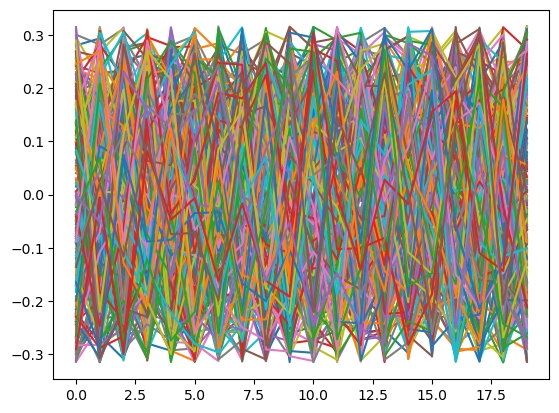

In [12]:
kernel = np.mean(K_kernel,axis=0)
plt.figure()
for i in range(256):
    plt.plot(K_kernel[i,:])

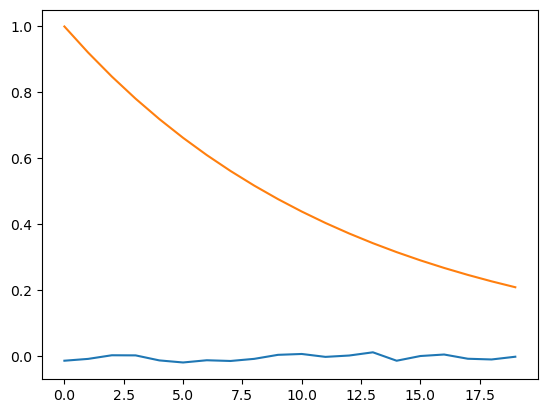

In [13]:
plt.plot(kernel)
plt.plot(pre_kernel)